# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [246]:
# Import libraries

import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout
from tensorflow.keras.layers import BatchNormalization, SpatialDropout1D, SimpleRNN, Dense, Dropout

from tensorflow.keras.models import load_model
import datetime
import random
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [247]:
# Define a function to load data and aggregate them


def load_and_aggregate_stock_data(filenames):
    dfs = []

    for file in filenames:

        # Extract stock names from file names
        stock_name = os.path.basename(file).split('_')[0]

        #Read the CSV files as data frames
        df = pd.read_csv(file)

        # Drop unnecessary 'Name' column
        df = df.drop(columns=['Name'])
        
        #Append stock name as prefix to each column 
        
        new_columns = []
        for col in df.columns:
            if col == 'Date':
                new_columns.append(col)
            else:
                new_columns.append(f"{stock_name}_{col}")
        
        df.columns = new_columns
        dfs.append(df)
        
    # Join all DataFrames into one 
    
    combined_df = dfs[0]
    for df in dfs[1:]:
        combined_df = pd.merge(combined_df, df, on='Date', how='inner')

    combined_df['Date'] = pd.to_datetime(combined_df['Date'])
    combined_df.sort_values('Date', inplace=True)
    combined_df.reset_index(drop=True, inplace=True)

    return combined_df


In [248]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files


filenames = [
    'AMZN_stocks_data.csv',
    'GOOGL_stocks_data.csv',
    'IBM_stocks_data.csv',
    'MSFT_stocks_data.csv'
]

stock_data = load_and_aggregate_stock_data(filenames)

In [249]:
# View specifics of the data

print(stock_data.head())

print("Shape of the data:", stock_data.shape)

print(stock_data.dtypes)

print(stock_data.describe())

        Date  AMZN_Open  AMZN_High  AMZN_Low  AMZN_Close  AMZN_Volume  \
0 2006-01-03      47.47      47.85     46.25       47.58      7582127   
1 2006-01-04      47.48      47.73     46.69       47.25      7440914   
2 2006-01-05      47.16      48.20     47.11       47.65      5417258   
3 2006-01-06      47.97      48.58     47.32       47.87      6154285   
4 2006-01-09      46.55      47.10     46.40       47.08      8945056   

   GOOGL_Open  GOOGL_High  GOOGL_Low  GOOGL_Close  ...  IBM_Open  IBM_High  \
0      211.47      218.05     209.32       217.83  ...     82.45     82.55   
1      222.17      224.70     220.09       222.84  ...     82.20     82.50   
2      223.22      226.00     220.97       225.85  ...     81.40     82.90   
3      228.66      235.49     226.85       233.06  ...     83.95     85.03   
4      233.44      236.94     230.70       233.68  ...     84.10     84.25   

   IBM_Low  IBM_Close  IBM_Volume  MSFT_Open  MSFT_High  MSFT_Low  MSFT_Close  \
0    80.81 

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [250]:
# Handle Missing Values
print(stock_data.isnull().sum())


Date            0
AMZN_Open       0
AMZN_High       0
AMZN_Low        0
AMZN_Close      0
AMZN_Volume     0
GOOGL_Open      0
GOOGL_High      0
GOOGL_Low       0
GOOGL_Close     0
GOOGL_Volume    0
IBM_Open        1
IBM_High        0
IBM_Low         1
IBM_Close       0
IBM_Volume      0
MSFT_Open       0
MSFT_High       0
MSFT_Low        0
MSFT_Close      0
MSFT_Volume     0
dtype: int64


In [251]:
print(stock_data.isnull().values.any())

True


In [252]:
stock_data[stock_data.isnull().any(axis=1)]

Date  AMZN_Open  AMZN_High  AMZN_Low  AMZN_Close  AMZN_Volume  \
2912 2017-07-31    1019.05    1019.05    987.02      987.78      7352063   

      GOOGL_Open  GOOGL_High  GOOGL_Low  GOOGL_Close  ...  IBM_Open  IBM_High  \
2912       960.0      961.19     941.72        945.5  ...       NaN    144.93   

      IBM_Low  IBM_Close  IBM_Volume  MSFT_Open  MSFT_High  MSFT_Low  \
2912      NaN     144.67     4355718       73.3      73.44     72.41   

      MSFT_Close  MSFT_Volume  
2912        72.7     23600054  

[1 rows x 21 columns]

In [253]:
stock_data.fillna(method='ffill',inplace=True)

In [254]:
print(stock_data.isnull().values.any())

False


In [255]:
stock_data.dtypes

Date            datetime64[ns]
AMZN_Open              float64
AMZN_High              float64
AMZN_Low               float64
AMZN_Close             float64
AMZN_Volume              int64
GOOGL_Open             float64
GOOGL_High             float64
GOOGL_Low              float64
GOOGL_Close            float64
GOOGL_Volume             int64
IBM_Open               float64
IBM_High               float64
IBM_Low                float64
IBM_Close              float64
IBM_Volume               int64
MSFT_Open              float64
MSFT_High              float64
MSFT_Low               float64
MSFT_Close             float64
MSFT_Volume              int64
dtype: object

### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

['AMZN_Volume', 'GOOGL_Volume', 'IBM_Volume', 'MSFT_Volume']


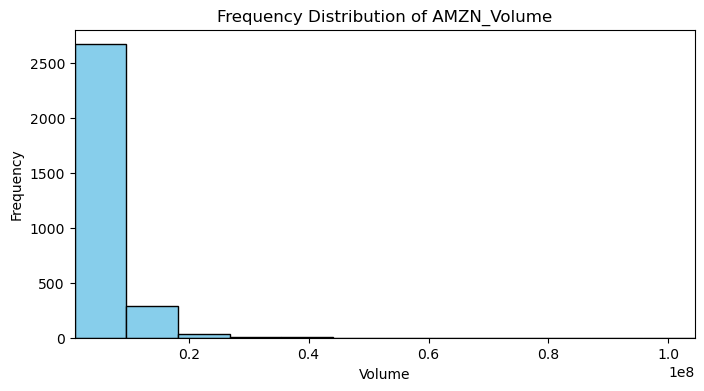

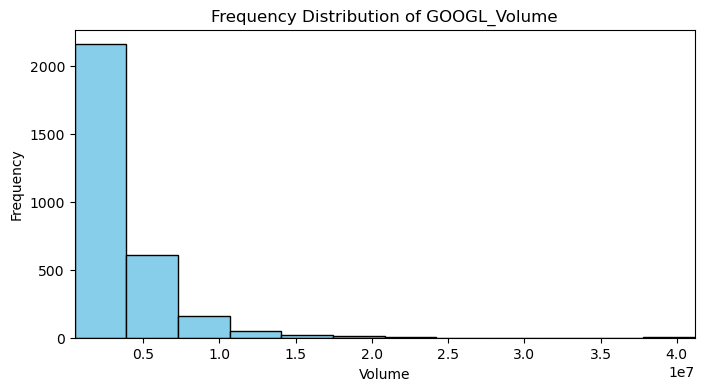

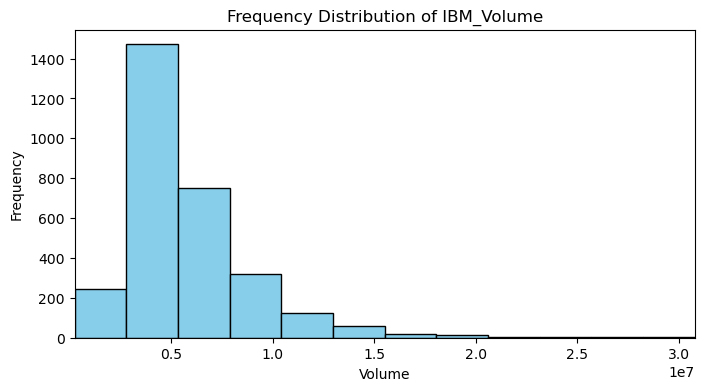

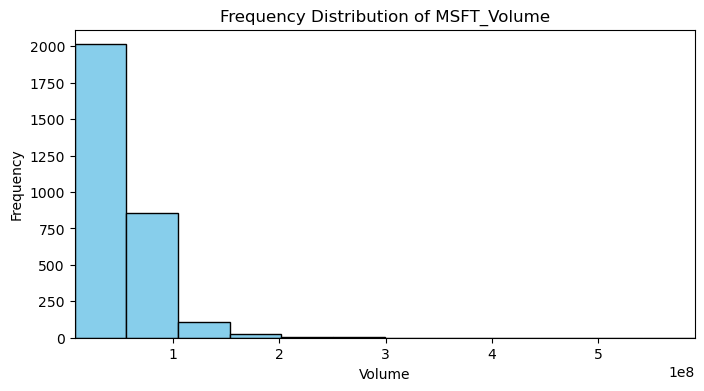

In [256]:
# Frequency distribution of volumes

volume_columns = [col for col in stock_data.columns if 'Volume' in col]
print(volume_columns)

for col in volume_columns:
    data = pd.to_numeric(stock_data[col], errors='coerce')
    plt.figure(figsize=(8, 4))
    plt.hist(stock_data[col], bins=12, color='skyblue', edgecolor='black')
    plt.title(f'Frequency Distribution of {col}')
    plt.xlabel('Volume')
    plt.ylabel('Frequency')
    plt.xlim(stock_data[col].min(), stock_data[col].max())
    plt.show()


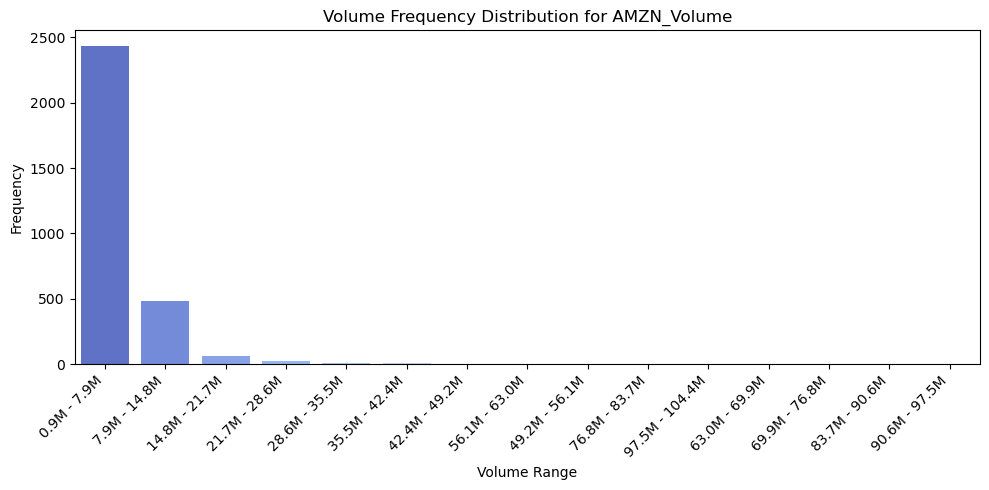

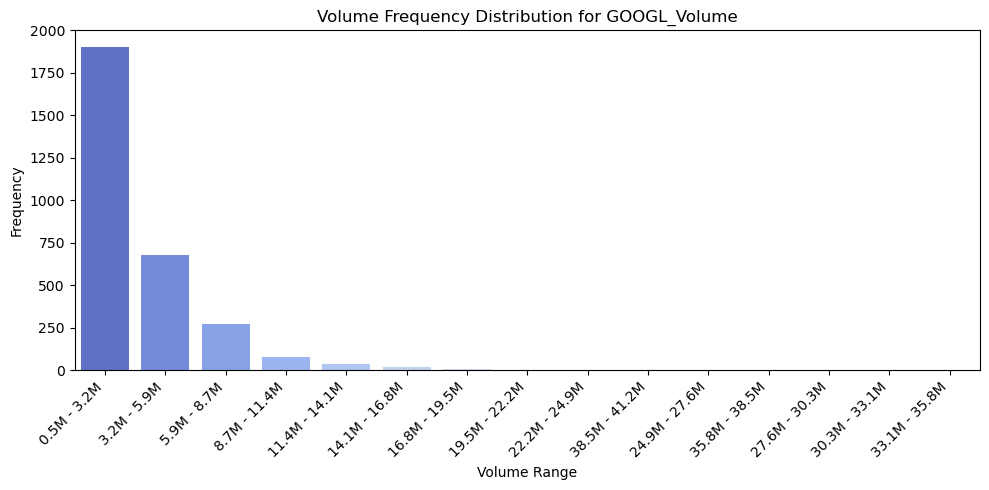

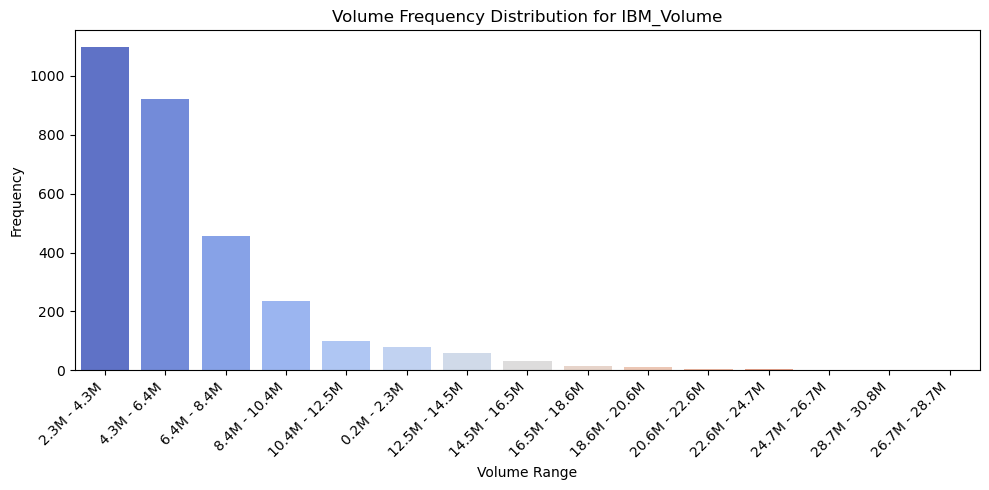

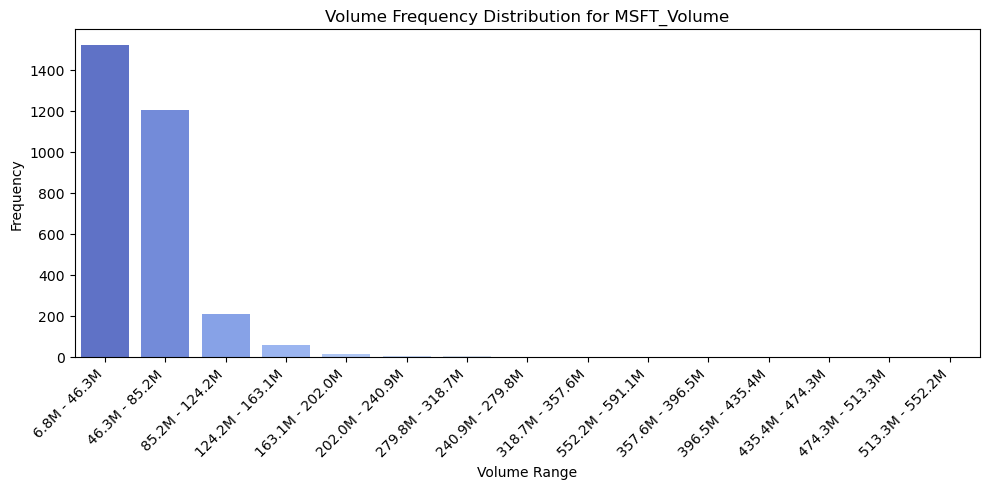

In [257]:
volume_columns = [col for col in stock_data.columns if col.endswith('_Volume')]

for col in volume_columns:
    plt.figure(figsize=(10, 5))
    volume_bins = pd.cut(stock_data[col], bins=15)
    freq_by_bin = volume_bins.value_counts()
    
     # Format bin labels to show in millions with one decimal
    labels = [f"{interval.left/1_000_000:.1f}M - {interval.right/1_000_000:.1f}M" for interval in freq_by_bin.index]
    
    sns.barplot(x=labels, y=freq_by_bin.values, palette="coolwarm")
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Volume Frequency Distribution for {col}')
    plt.xlabel('Volume Range')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

In [258]:

volume_columns = [col for col in stock_data.columns if col.endswith('_Volume')]

for col in volume_columns:
    print(f"Frequency distribution for {col}:")
    volume_bins = pd.cut(stock_data[col], bins=10)
    freq_by_bin = volume_bins.value_counts().sort_index()
    print(freq_by_bin)
    print("\n" + "-"*50 + "\n")


Frequency distribution for AMZN_Volume:
AMZN_Volume
(883016.846, 11328250.4]     2799
(11328250.4, 21670065.8]      178
(21670065.8, 32011881.2]       24
(32011881.2, 42353696.6]        8
(42353696.6, 52695512.0]        5
(52695512.0, 63037327.4]        3
(63037327.4, 73379142.8]        0
(73379142.8, 83720958.2]        1
(83720958.2, 94062773.6]        0
(94062773.6, 104404589.0]       1
Name: count, dtype: int64

--------------------------------------------------

Frequency distribution for GOOGL_Volume:
GOOGL_Volume
(480479.252, 4587315.8]     2345
(4587315.8, 8653490.6]       513
(8653490.6, 12719665.4]      103
(12719665.4, 16785840.2]      35
(16785840.2, 20852015.0]      14
(20852015.0, 24918189.8]       5
(24918189.8, 28984364.6]       1
(28984364.6, 33050539.4]       0
(33050539.4, 37116714.2]       1
(37116714.2, 41182889.0]       2
Name: count, dtype: int64

--------------------------------------------------

Frequency distribution for IBM_Volume:
IBM_Volume
(223735.98, 3306

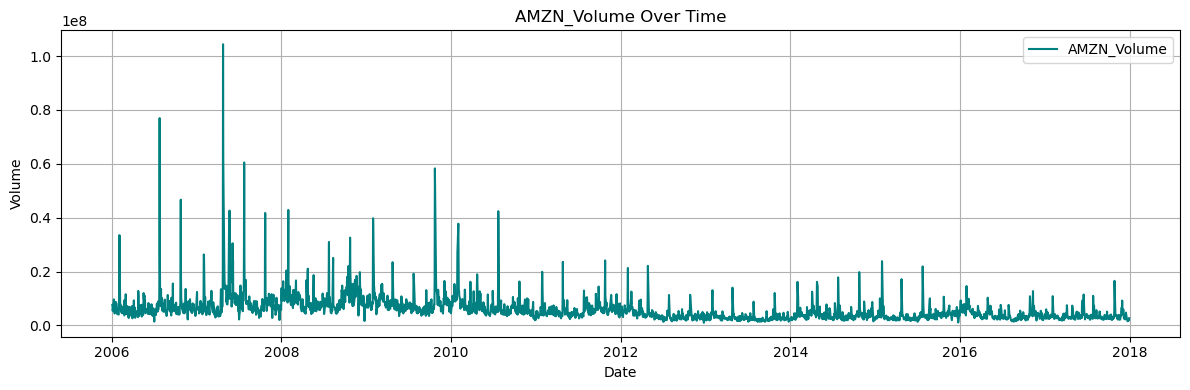

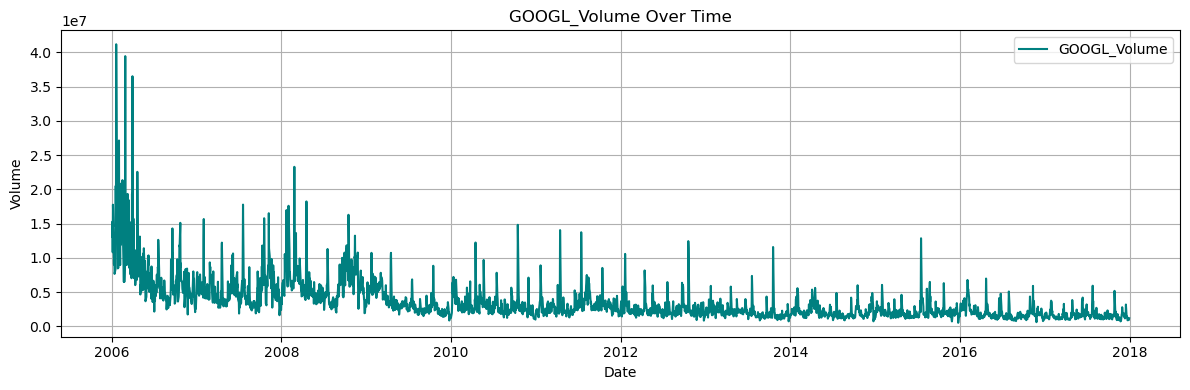

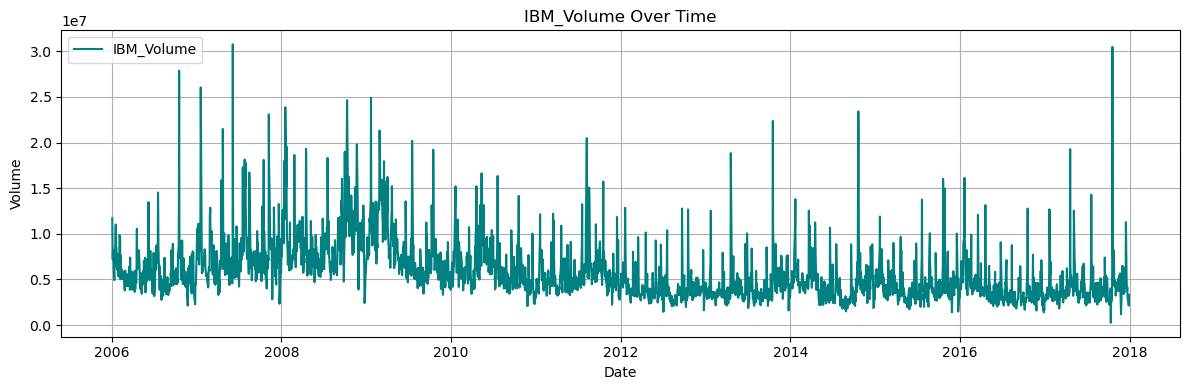

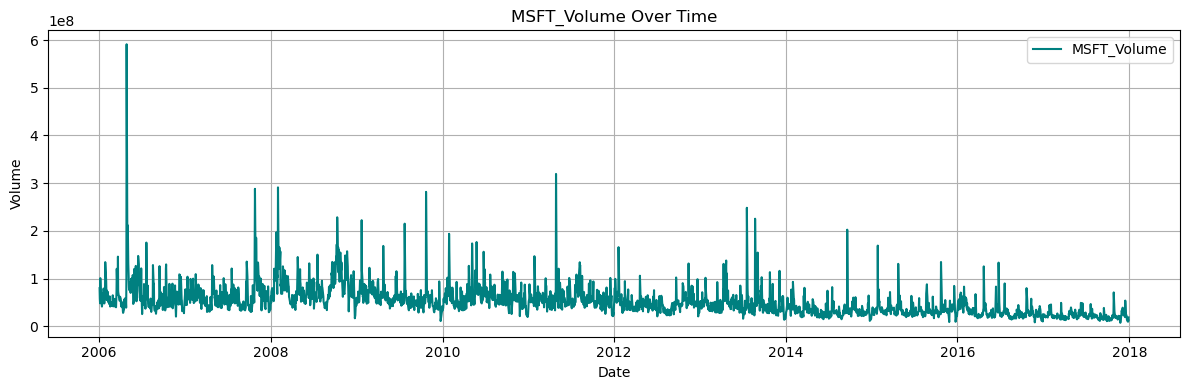

In [259]:
# Stock volume variation over time

volume_columns = [col for col in stock_data.columns if 'Volume' in col]

# Plot time series of volume for each stock
for col in volume_columns:
    plt.figure(figsize=(12, 4))
    plt.plot(stock_data['Date'], stock_data[col], label=col, color='teal')
    plt.title(f'{col} Over Time')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.tight_layout()
    plt.grid(True)
    plt.legend()
    plt.show()


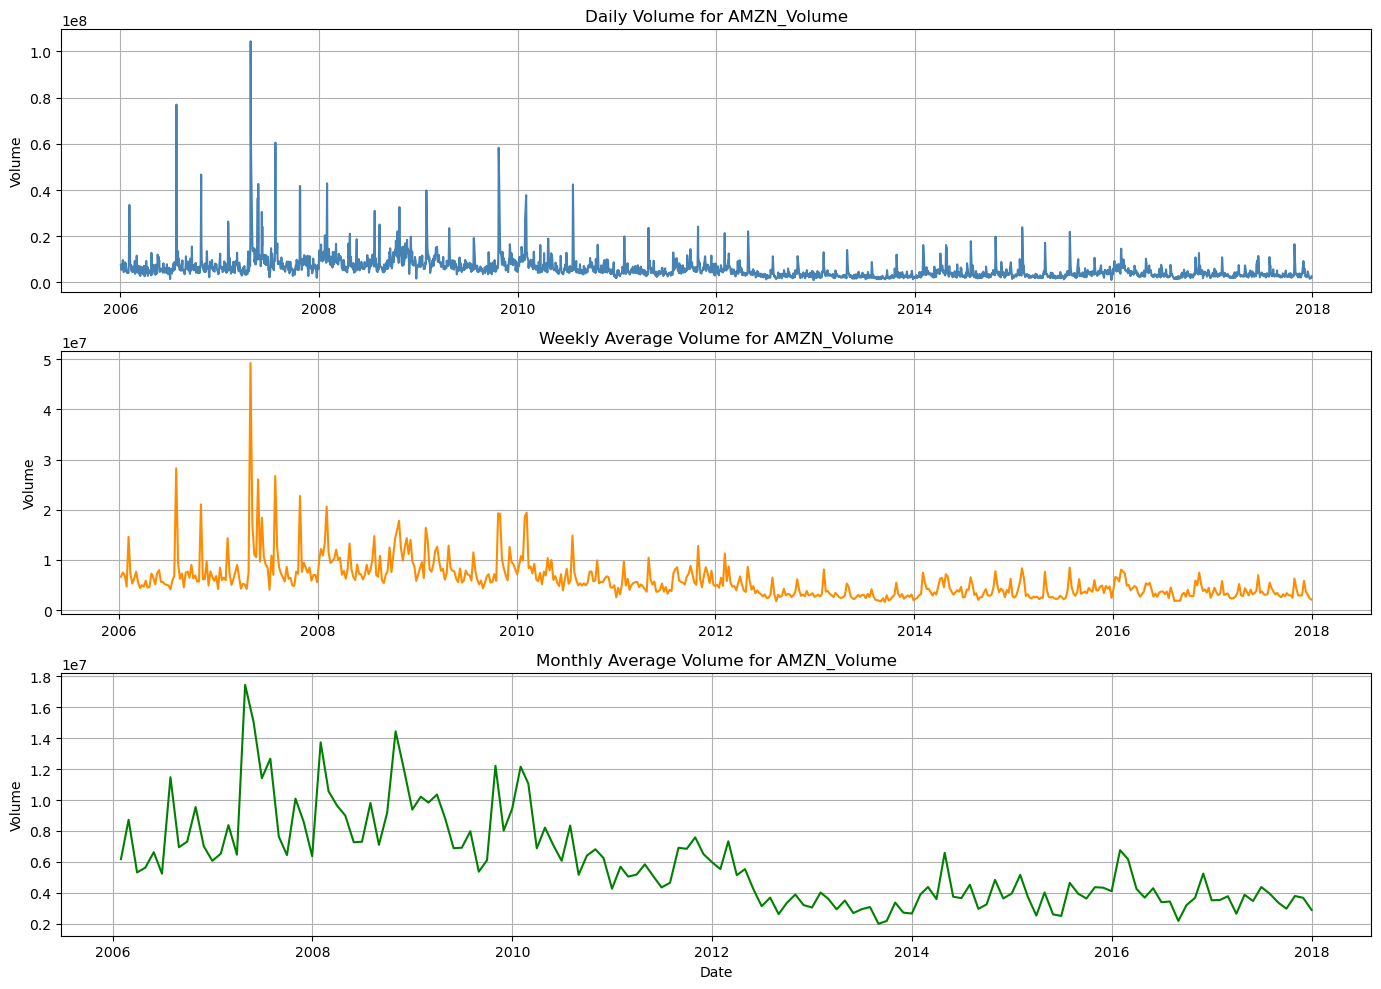

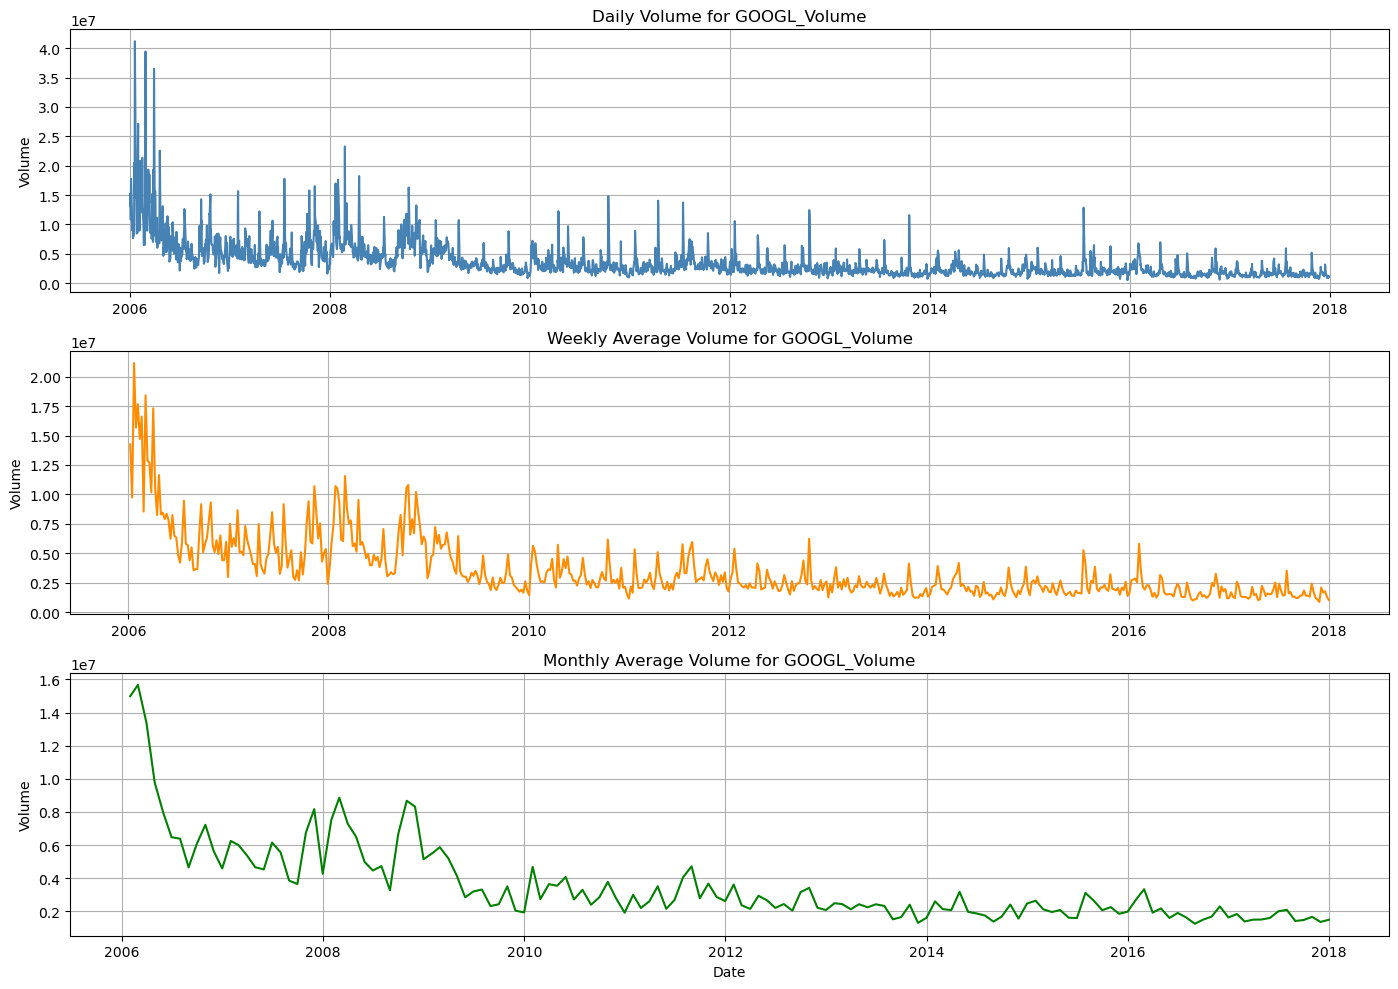

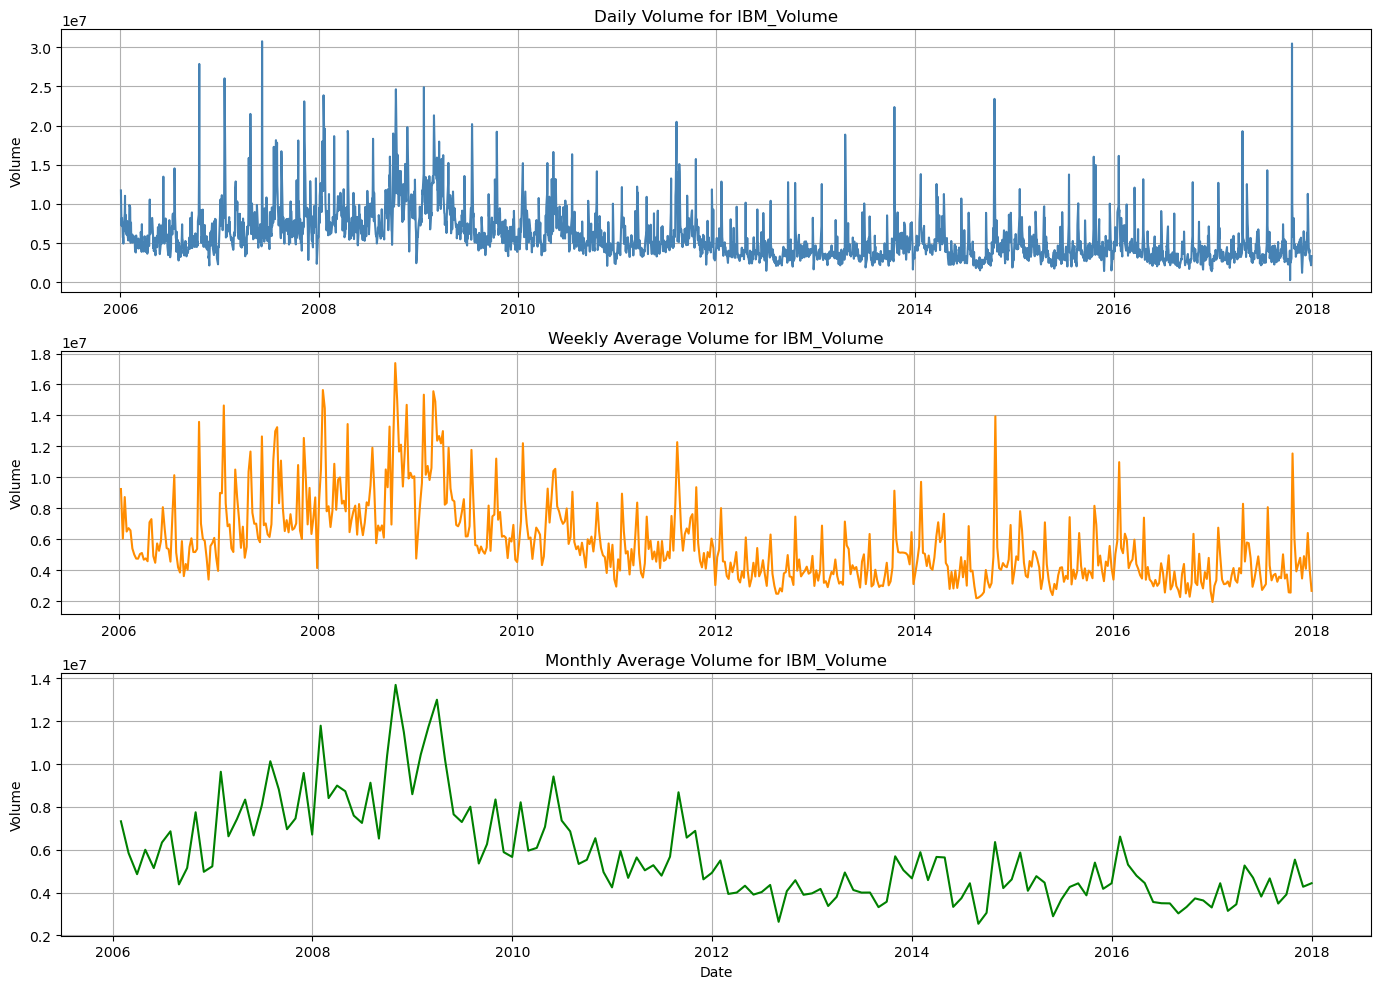

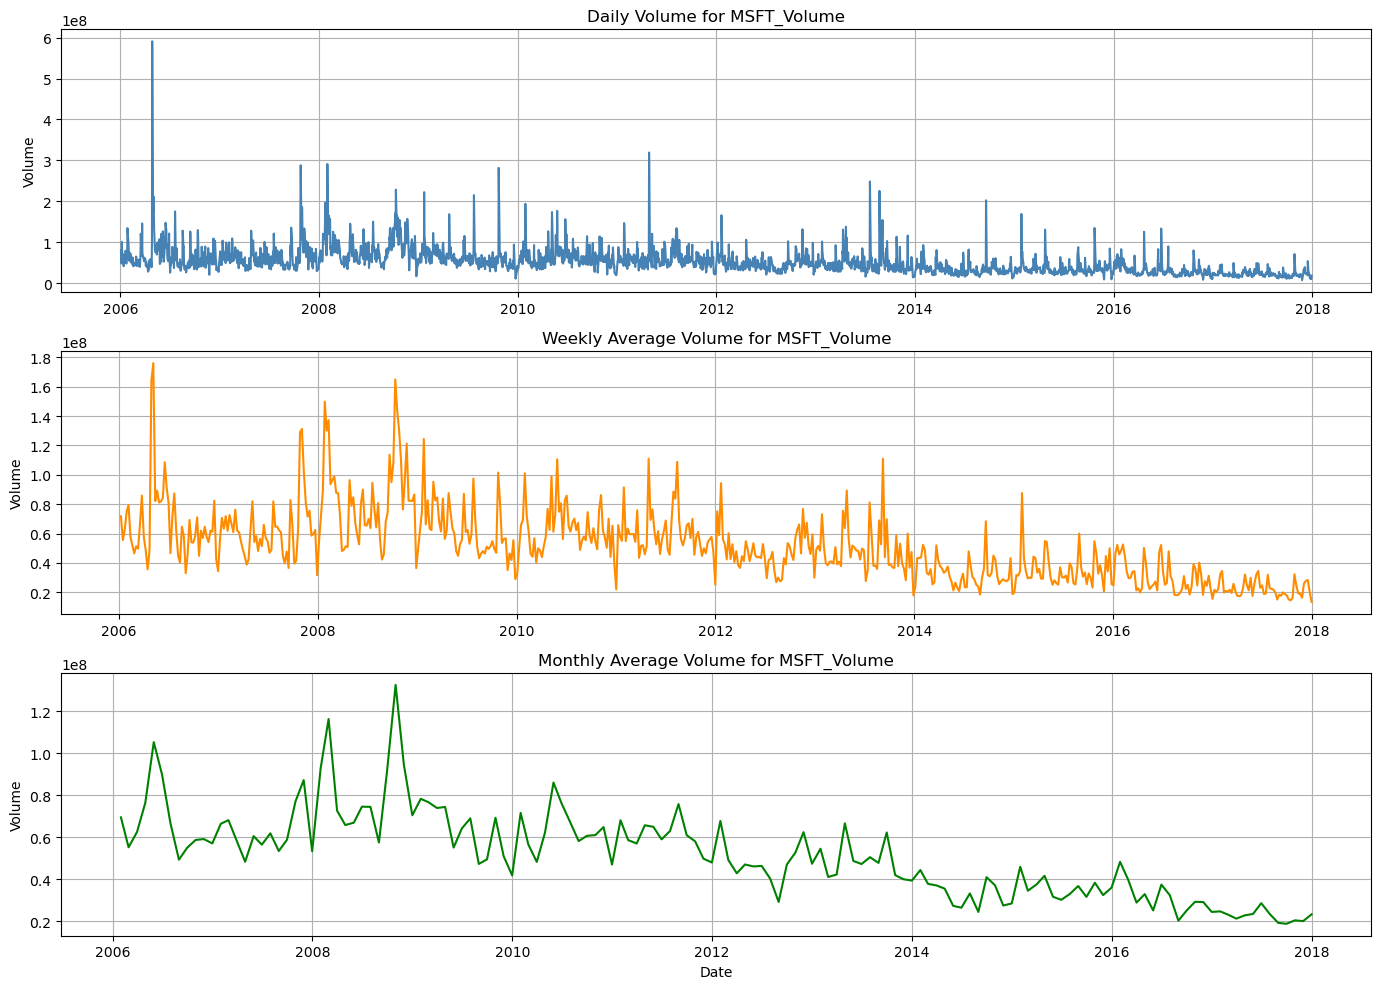

In [260]:

stock_data.set_index('Date', inplace=True)

volume_columns = [col for col in stock_data.columns if 'Volume' in col]

for col in volume_columns:
    plt.figure(figsize=(14, 10))

    # Daily Volume
    plt.subplot(3, 1, 1)
    plt.plot(stock_data.index, stock_data[col], color='steelblue')
    plt.title(f'Daily Volume for {col}')
    plt.ylabel('Volume')
    plt.grid(True)

    # Weekly Volume 
    weekly = stock_data[col].resample('W').mean()
    plt.subplot(3, 1, 2)
    plt.plot(weekly.index, weekly, color='darkorange')
    plt.title(f'Weekly Average Volume for {col}')
    plt.ylabel('Volume')
    plt.grid(True)

    # Monthly Volume
    monthly = stock_data[col].resample('M').mean()
    plt.subplot(3, 1, 3)
    plt.plot(monthly.index, monthly, color='green')
    plt.title(f'Monthly Average Volume for {col}')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


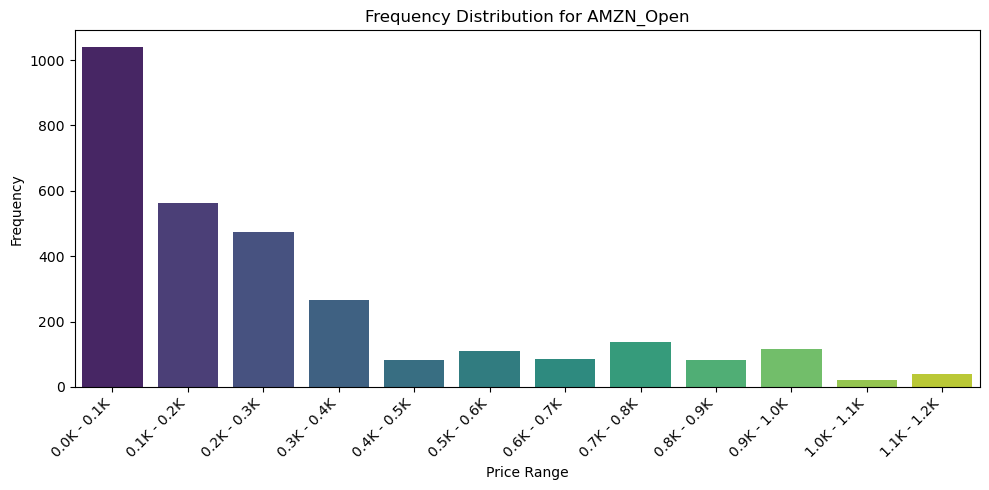

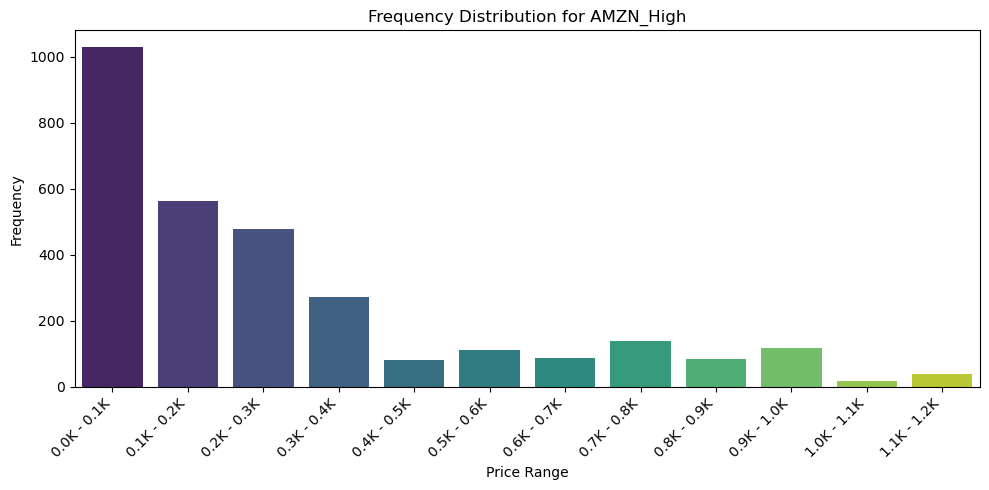

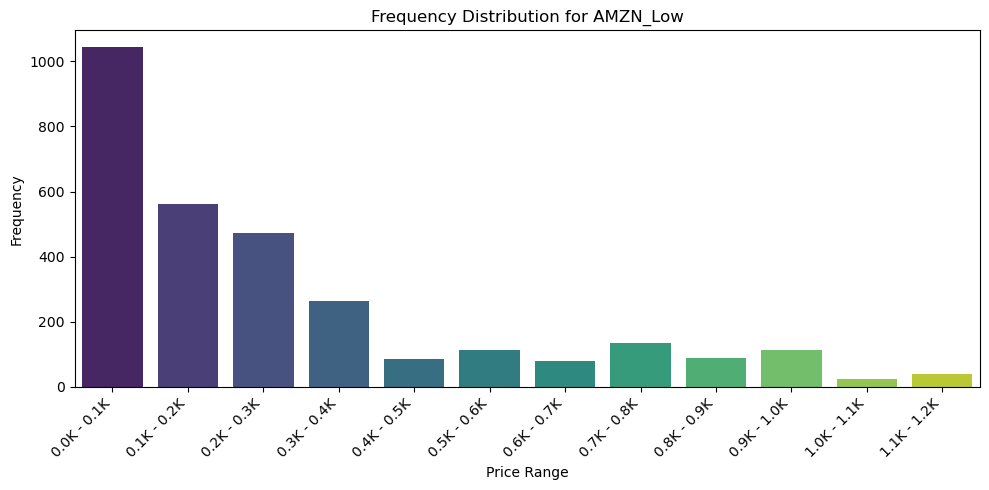

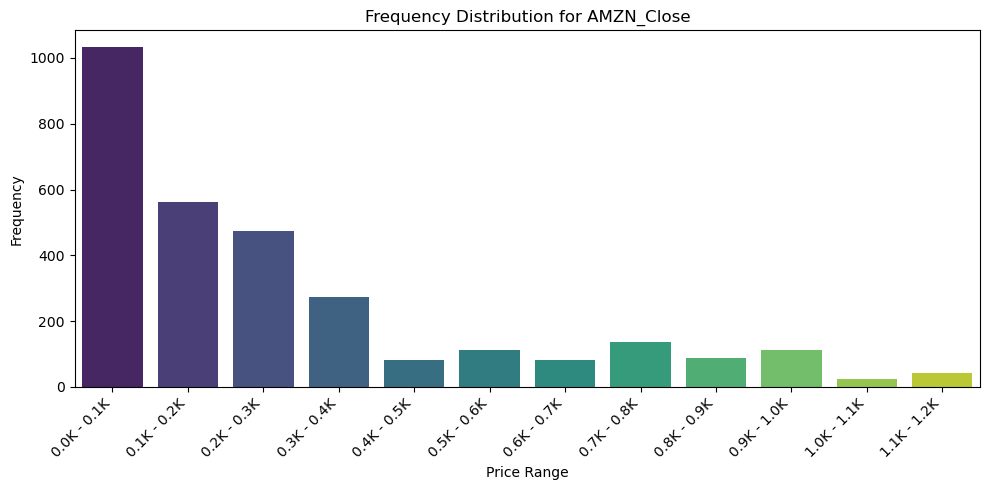

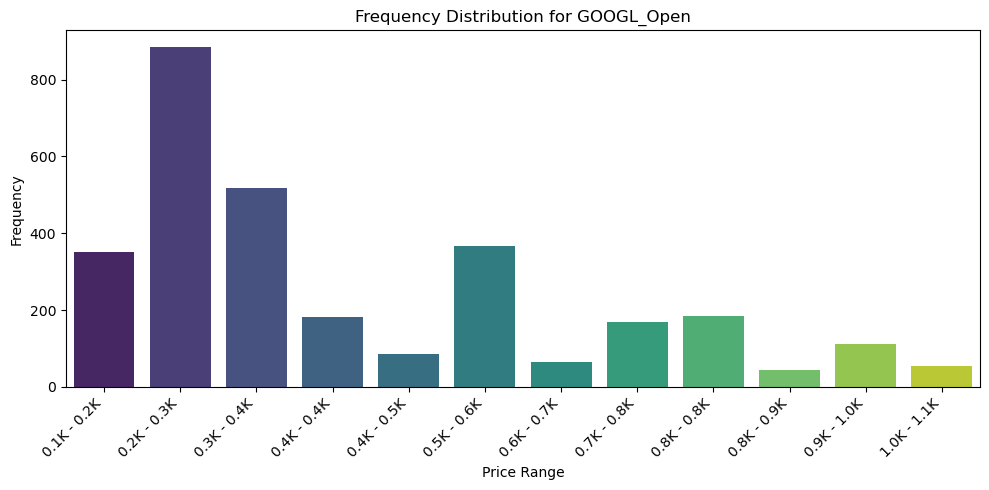

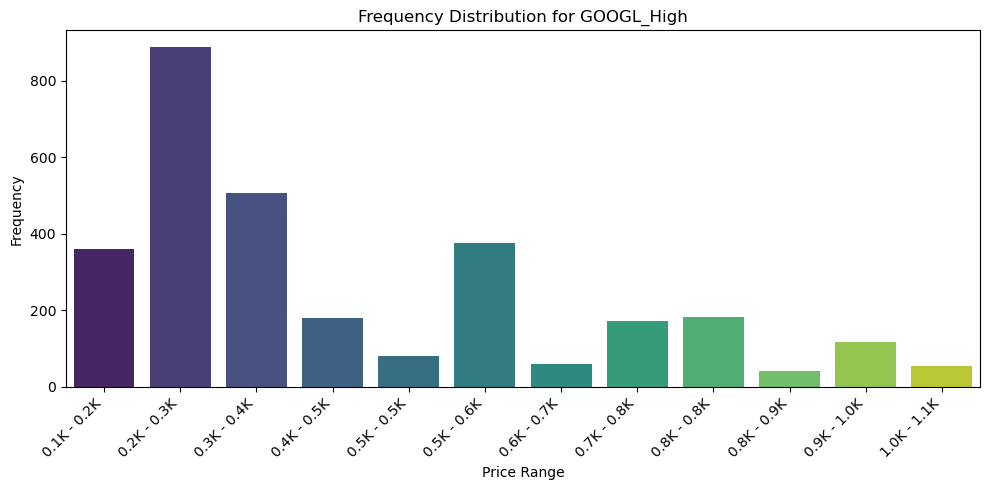

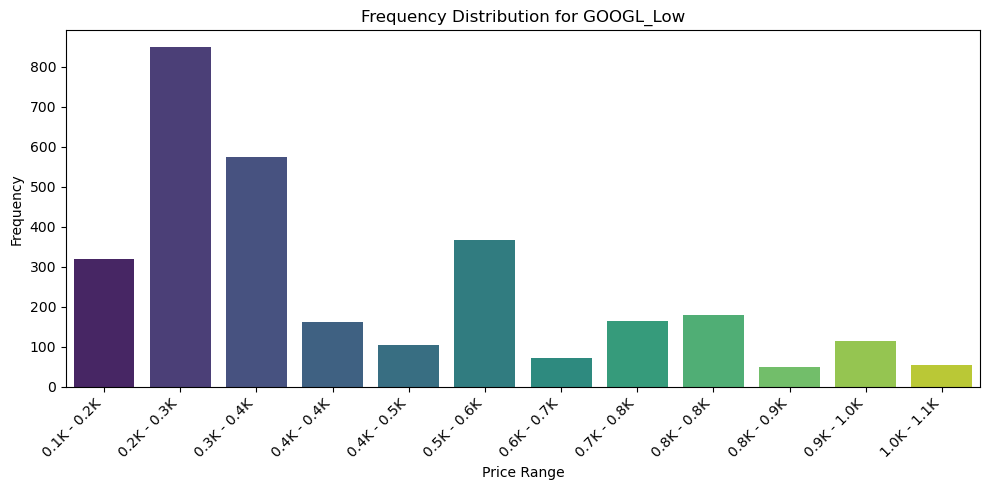

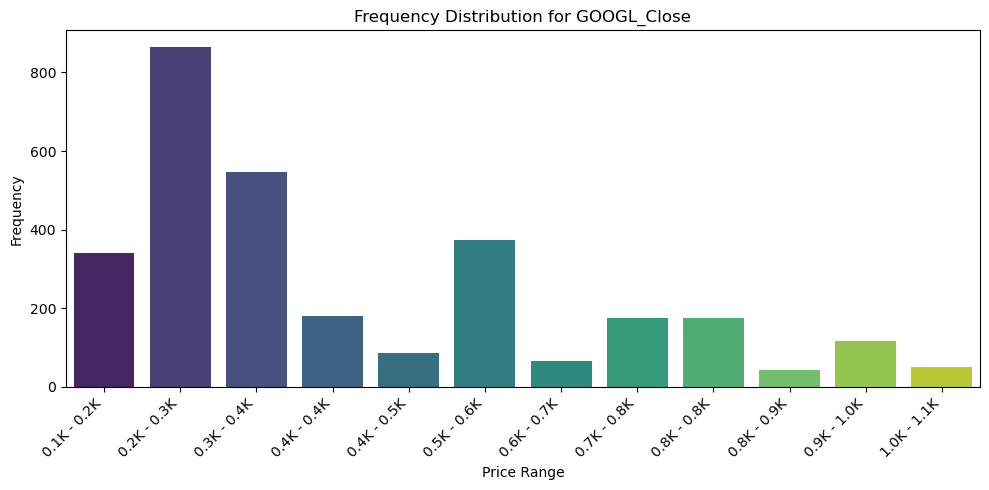

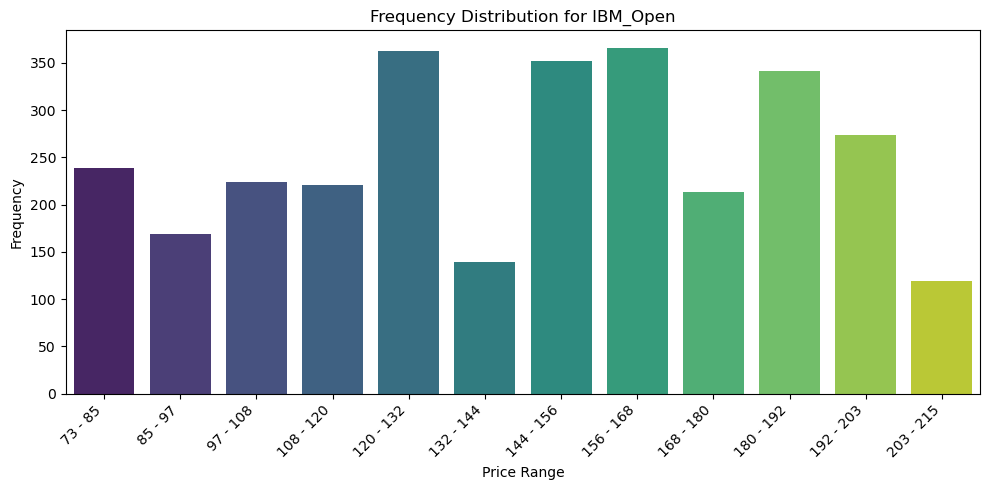

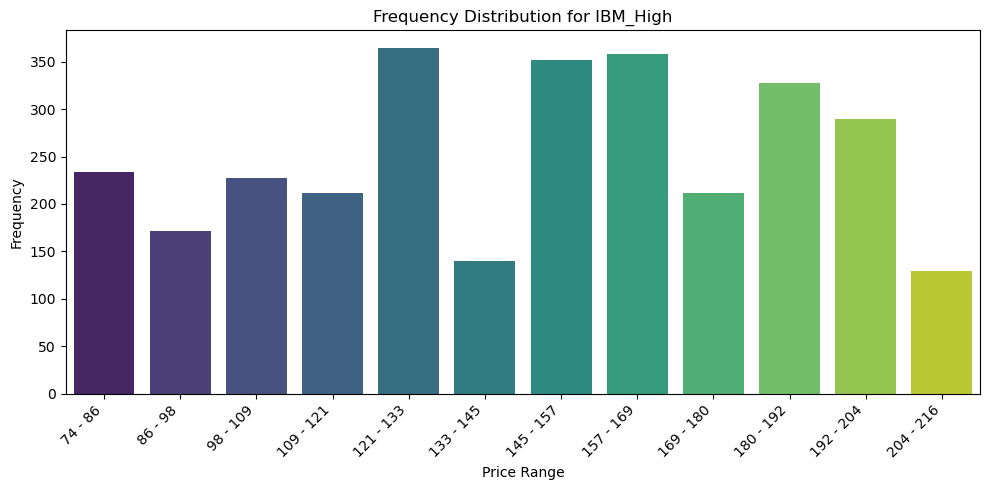

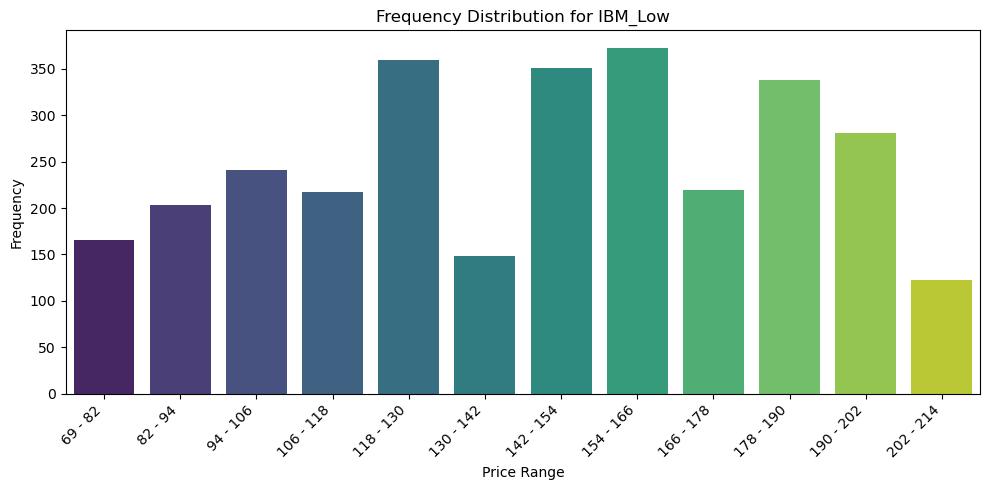

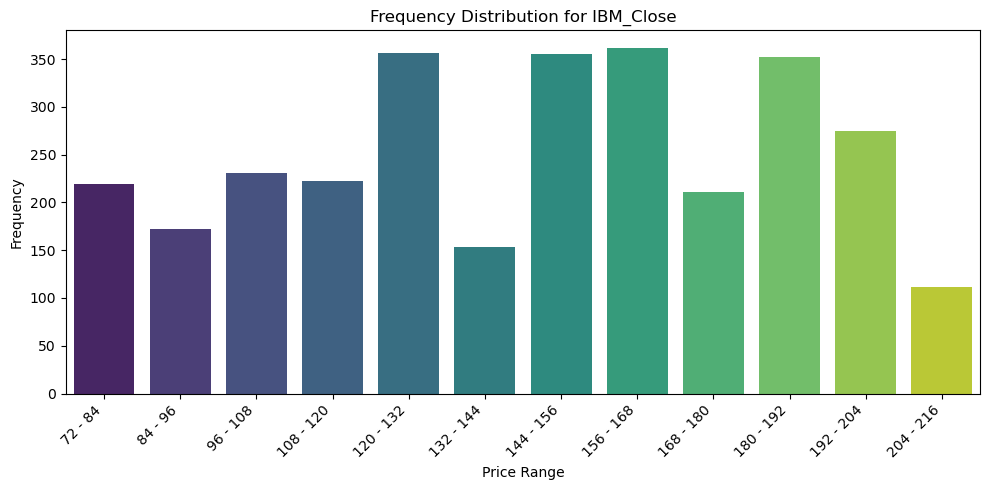

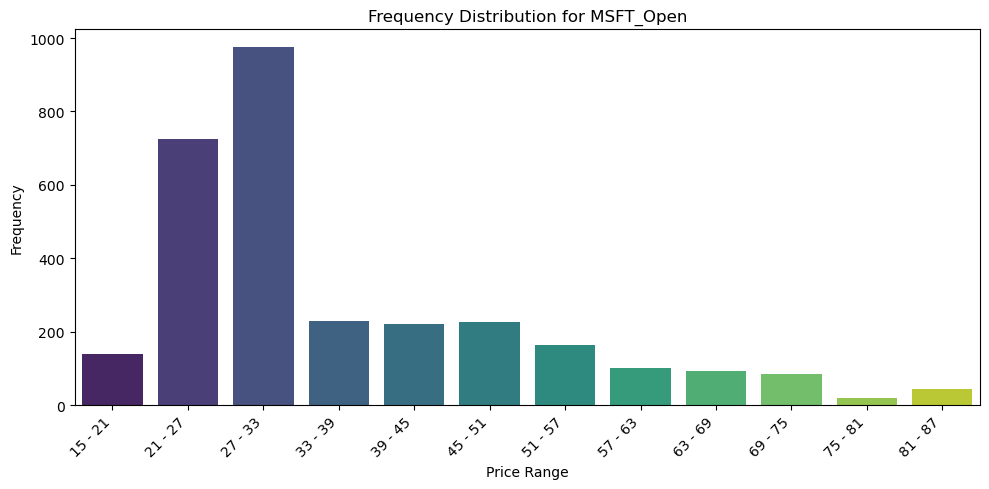

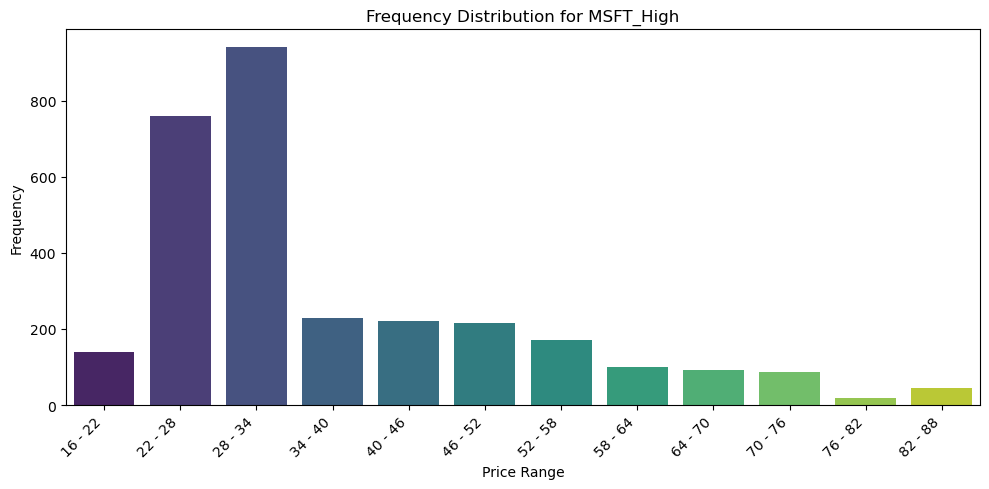

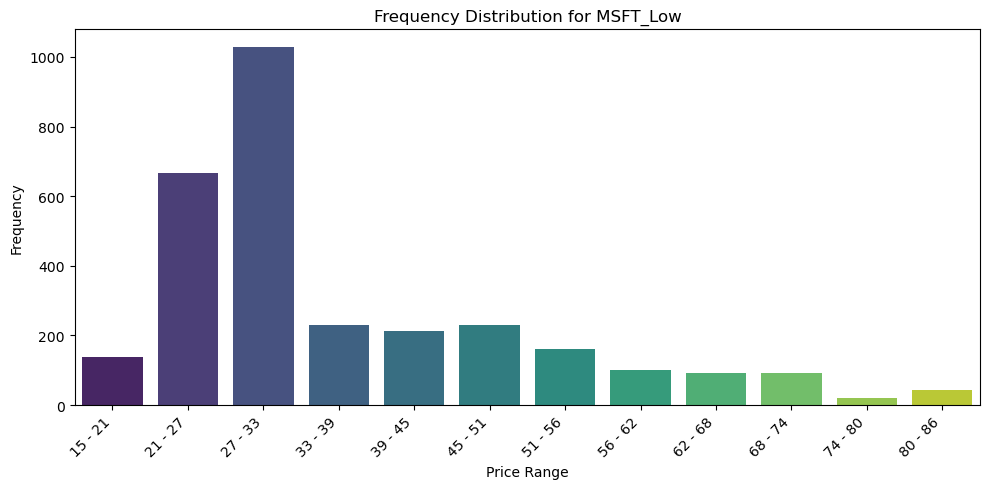

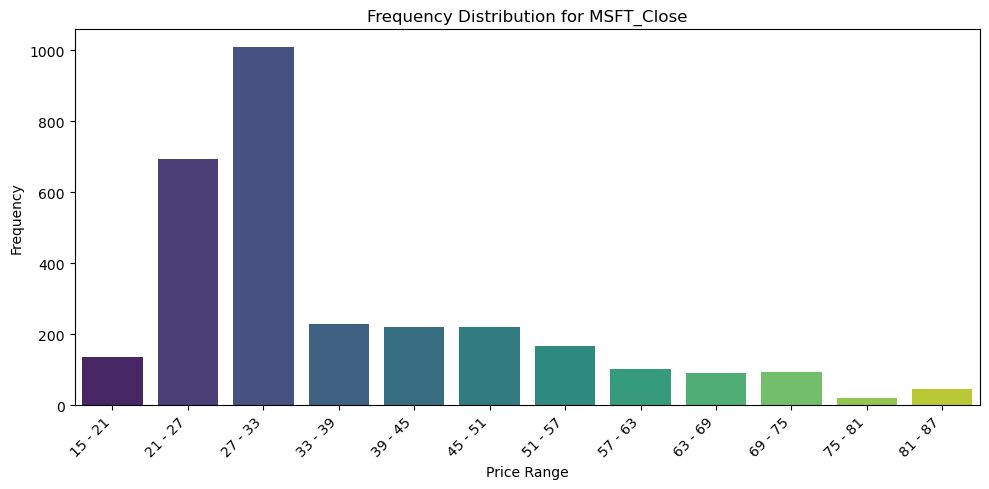

In [261]:

price_columns = [col for col in stock_data.columns if col.endswith(('_Open', '_Close', '_High', '_Low'))]

# Loop through each price column
for col in price_columns:
    plt.figure(figsize=(10, 5))
    
    price_bins = pd.cut(stock_data[col], bins=12)
    freq_by_bin = price_bins.value_counts().sort_index()

    max_val = stock_data[col].max()
    if max_val > 1_000_000:
        labels = [f"{interval.left/1_000_000:.1f}M - {interval.right/1_000_000:.1f}M" for interval in freq_by_bin.index]
    elif max_val > 1_000:
        labels = [f"{interval.left/1_000:.1f}K - {interval.right/1_000:.1f}K" for interval in freq_by_bin.index]
    else:
        labels = [f"{interval.left:.0f} - {interval.right:.0f}" for interval in freq_by_bin.index]

    sns.barplot(x=labels, y=freq_by_bin.values, palette="viridis")
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Frequency Distribution for {col}')
    plt.xlabel('Price Range')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

In [262]:
stock_data.head(5)

AMZN_Open  AMZN_High  AMZN_Low  AMZN_Close  AMZN_Volume  \
Date                                                                  
2006-01-03      47.47      47.85     46.25       47.58      7582127   
2006-01-04      47.48      47.73     46.69       47.25      7440914   
2006-01-05      47.16      48.20     47.11       47.65      5417258   
2006-01-06      47.97      48.58     47.32       47.87      6154285   
2006-01-09      46.55      47.10     46.40       47.08      8945056   

            GOOGL_Open  GOOGL_High  GOOGL_Low  GOOGL_Close  GOOGL_Volume  \
Date                                                                       
2006-01-03      211.47      218.05     209.32       217.83      13137450   
2006-01-04      222.17      224.70     220.09       222.84      15292353   
2006-01-05      223.22      226.00     220.97       225.85      10815661   
2006-01-06      228.66      235.49     226.85       233.06      17759521   
2006-01-09      233.44      236.94     230.70       233.68      12795837   

            IBM_Open  IBM_High  IBM_Low  IBM_Close  IBM_Volume  MSFT_Open  \
Date                                                                        
2006-01-03     82.45     82.55    80.81      82.06    11715200      26.25   
2006-01-04     82.20     82.50    81.33      81.95     9840600      26.77   
2006-01-05     81.40     82.90    81.00      82.50     7213500      26.96   
2006-01-06     83.95     85.03    83.41      84.95     8197400      26.89   
2006-01-09     84.10     84.25    83.38      83.73     6858200      26.93   

            MSFT_High  MSFT_Low  MSFT_Close  MSFT_Volume  
Date                                                      
2006-01-03      27.00     26.10       26.84     79974418  
2006-01-04      27.08     26.77       26.97     57975661  
2006-01-05      27.13     26.91       26.99     48247610  
2006-01-06      27.00     26.49       26.91    100969092  
2006-01-09      27.07     26.76       26.86     55627836

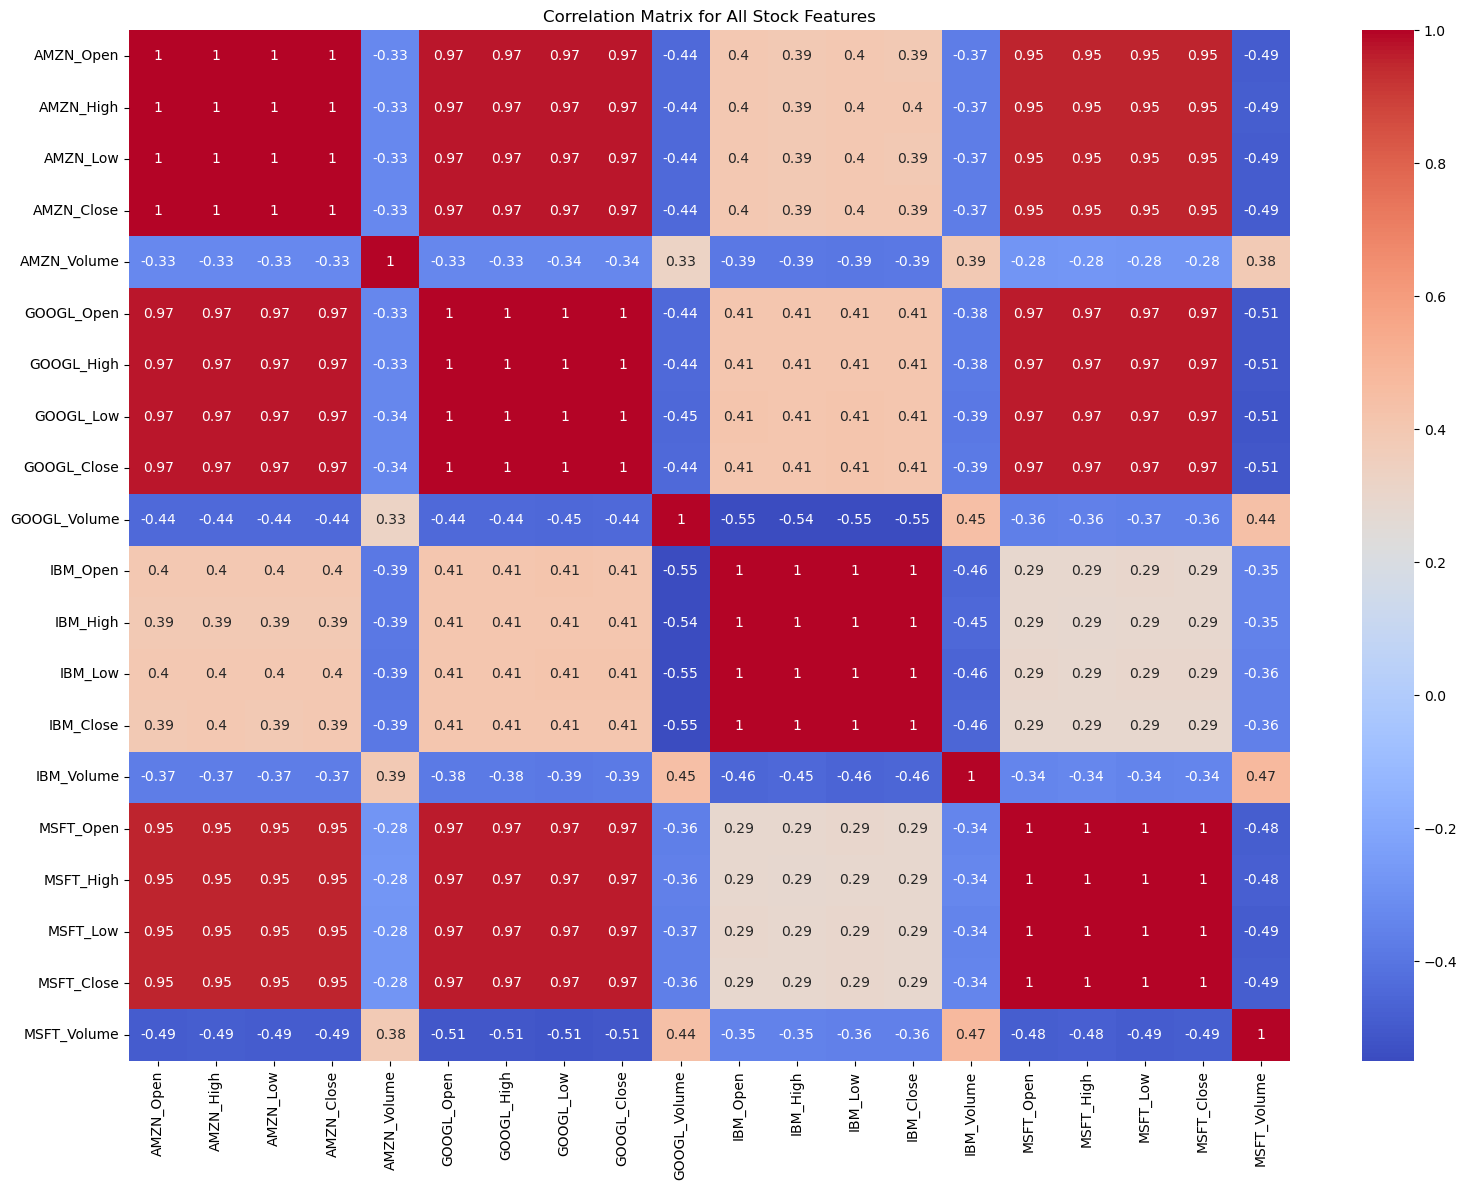

In [263]:
# Analyse correlations

correlation_matrix = stock_data.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for All Stock Features')
plt.tight_layout()
plt.show()

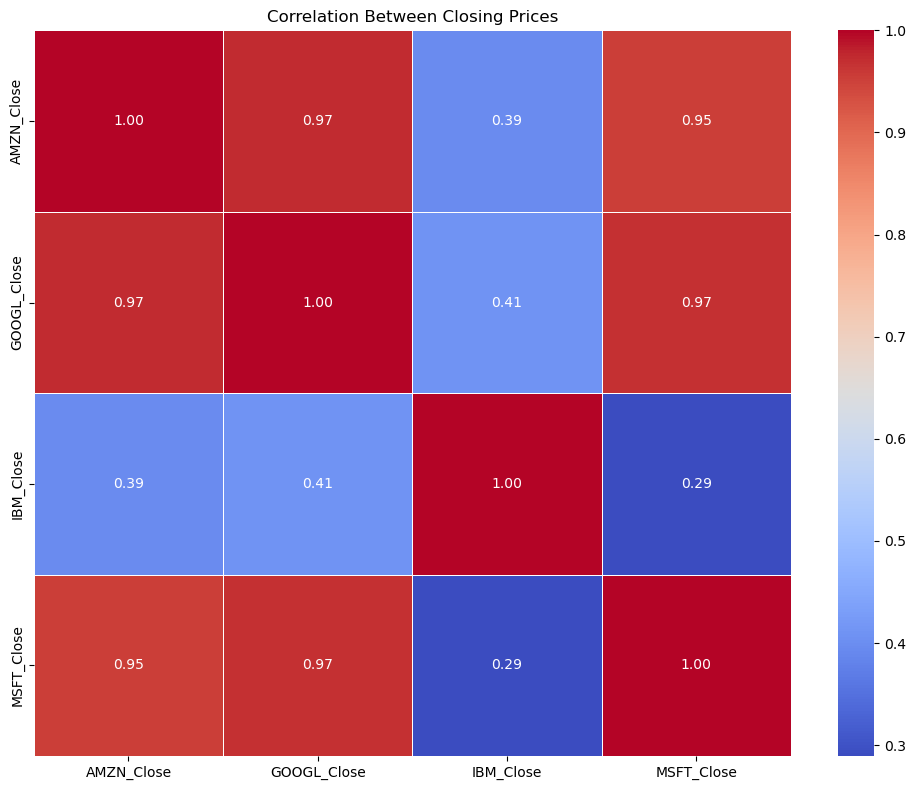

Correlation between closing prices:
             AMZN_Close  GOOGL_Close  IBM_Close  MSFT_Close
AMZN_Close     1.000000     0.972854   0.394932    0.953656
GOOGL_Close    0.972854     1.000000   0.410302    0.968973
IBM_Close      0.394932     0.410302   1.000000    0.289231
MSFT_Close     0.953656     0.968973   0.289231    1.000000


In [264]:
close_cols = [col for col in stock_data.columns if 'Close' in col]
close_cols

close_corr = stock_data[close_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(close_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Between Closing Prices')
plt.tight_layout()
plt.show()

print("Correlation between closing prices:")
print(close_corr)

###  Correlation Analysis Summary

- **`AMZN_Open` is very strongly correlated with `AMZN_Close` (0.999)**  
- **`AMZN_Open` and `GOOGL_Open` also have a strong correlation (0.973)**  
- **`AMZN_Open` and `IBM_Close` have a moderate correlation (0.395)**  
- **`AMZN_Open` and `MSFT_Open` show strong correlation (0.954)**  

This implies that prices across these tech companies **tend to move together**, which is expected as they belong to the **same sector**.

---

###  Interesting Observations

- **Same stock columns** like `GOOGL_Open`, `GOOGL_High`, etc. are **nearly perfectly correlated** (close to 1.0).  
  This is typical because they move together during trading.

- **Volume columns** show **negative correlations with price columns**, e.g.,  
  `AMZN_Volume` and `AMZN_Close`: **−0.327**.  
  This might suggest **higher volumes on downward price movements** 

- **`IBM` columns have relatively lower correlation** with others.  
  IBM might be **moving more independently** than the other tech stocks.


### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [265]:
# Define a function that divides the data into windows and generates target variable values for each window

def create_windowed_data(df, window_size, step_size, target_names):
    X_windows = []
    y_values = []

    for i in range(0, len(df) - window_size - 1, step_size):
        window = df.iloc[i : i+window_size].copy()
        target_vals = df.iloc[i+window_size][target_names].values
        if 'Date' in window.columns:
            window = window.drop('Date', axis=1)
        X_windows.append(window)
        y_values.append(target_vals)

    y_values = np.array(y_values)
    return X_windows, y_values


#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [266]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

#without looking ahead in next window we scale 

def scale_windowed_data(X_windows_train, X_windows_test, y_train, y_test, scaling_method='minmax'):
    if scaling_method == 'minmax':
        feature_scaler = MinMaxScaler()
        target_scaler = MinMaxScaler()
    else:
        feature_scaler = StandardScaler()
        target_scaler = StandardScaler()

    for window in X_windows_train:
        feature_scaler.partial_fit(window.values)

    X_train_scaled = np.array([feature_scaler.transform(window.values) for window in X_windows_train])
    
    X_test_scaled = np.array([feature_scaler.transform(window.values) for window in X_windows_test])

    target_scaler.fit(y_train)
    y_train_scaled = target_scaler.transform(y_train)
    y_test_scaled = target_scaler.transform(y_test)

    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler


Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [267]:
# Define a function to create input and output data points from the master DataFrame

def prepare_data_for_rnn(df, target_names, window_size=30, step_size=1, test_split=0.2, scaling_method='minmax'):
    # 1. Create windowed data (input features X and targets y)
    X_windows, y_values = create_windowed_data(df, window_size, step_size, target_names)

    # 2. Calculate split index to separate training and testing data
    split_idx = int(len(X_windows) * (1 - test_split))

    # 3. Split windows and targets into training and testing sets
    X_train = X_windows[:split_idx]
    X_test = X_windows[split_idx:]
    y_train = y_values[:split_idx]
    y_test = y_values[split_idx:]

    # 4. Scale features and targets using the selected scaling method
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler = scale_windowed_data(
        X_train, X_test, y_train, y_test, scaling_method
    )

    # 5. Return scaled datasets and scalers for further use
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler


We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

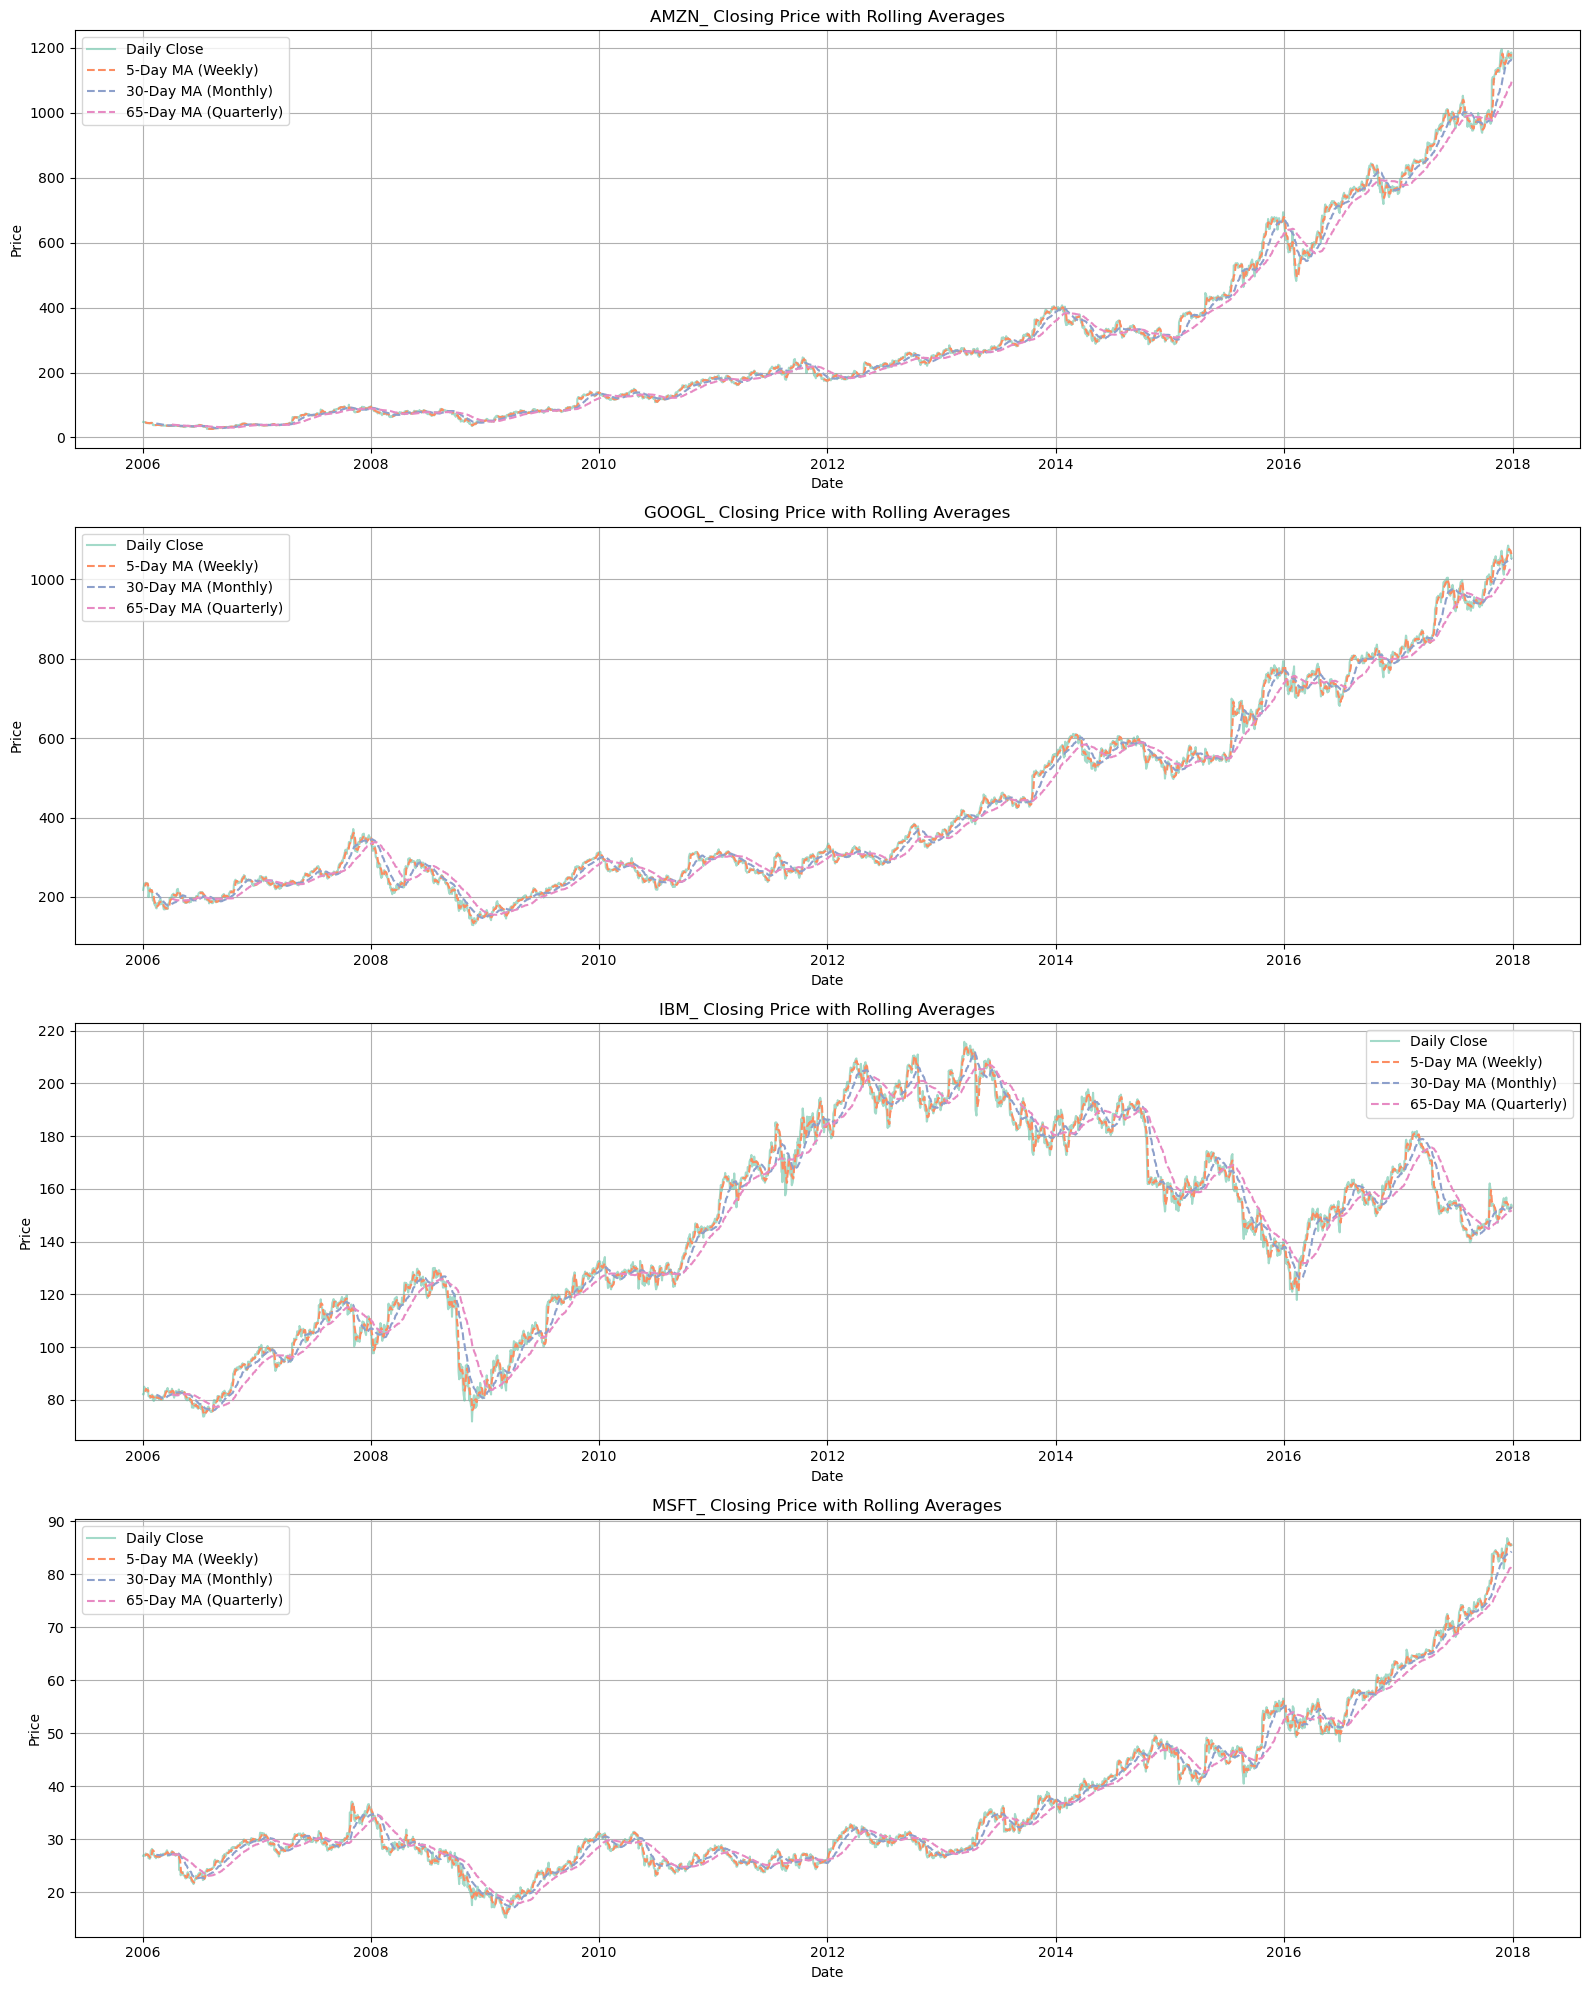

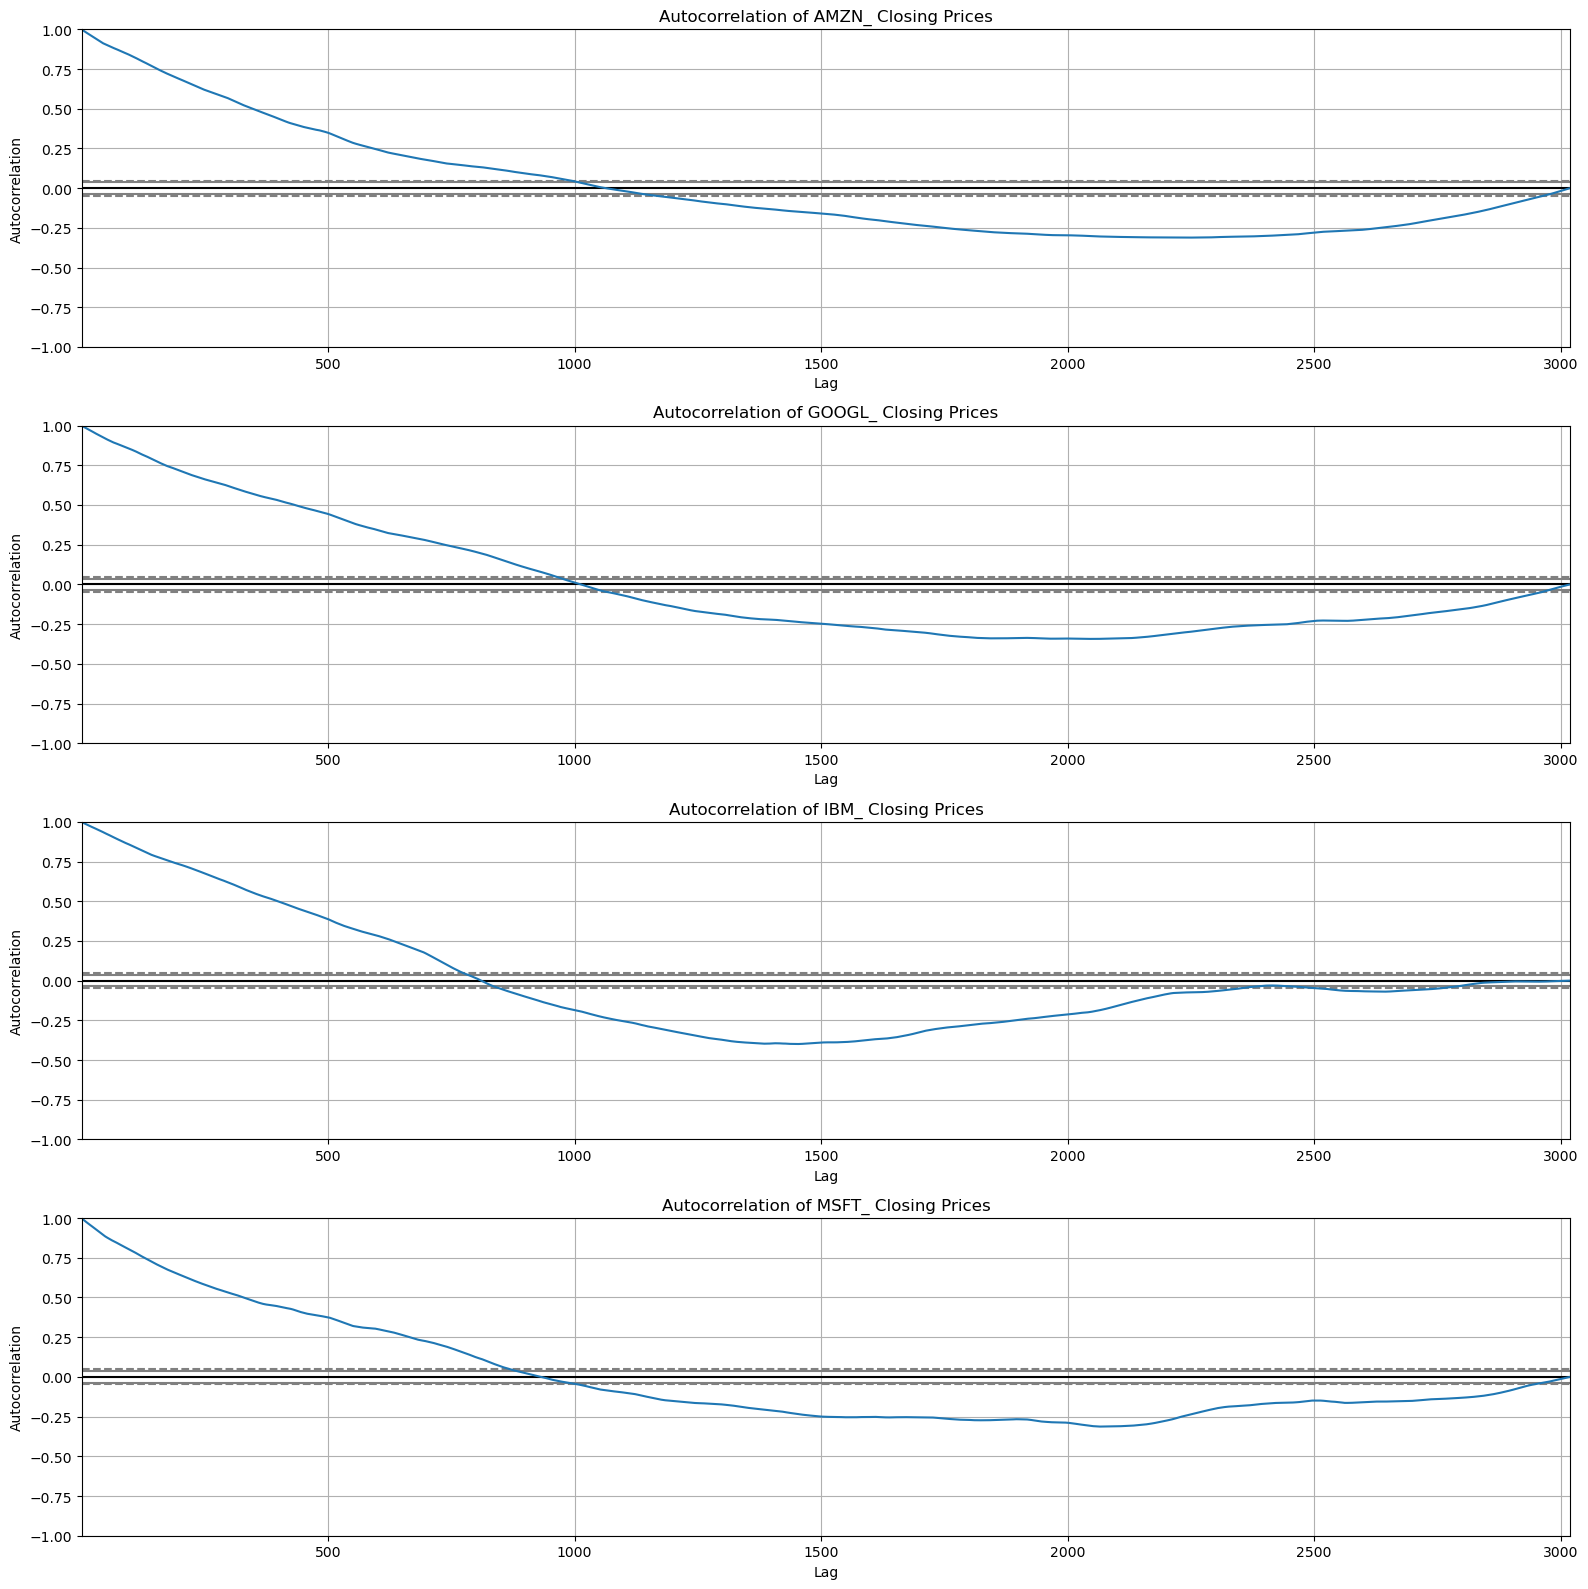


 Chosen window size: 30 days (≈ 1 business month)
Reasoning:
- 5-day MA is too reactive and noisy.
- 65-day MA is too smooth and lags behind trends.
- 30-day MA offers a balance between trend detection and noise reduction.


In [268]:
# Checking for patterns in different sequence lengths

weekly_window = 5
monthly_window = 30
quarterly_window = 65

close_cols = [col for col in stock_data.columns if 'Close' in col]
companies = [col.replace('Close', '').strip() for col in close_cols]

plt.figure(figsize=(16, 5 * len(close_cols)))
colors = sns.color_palette("Set2", 4)

for i, (col, company) in enumerate(zip(close_cols, companies), 1):
    plt.subplot(len(close_cols), 1, i)
    plt.plot(stock_data.index, stock_data[col], label='Daily Close', color=colors[0], alpha=0.6)
    plt.plot(stock_data.index, stock_data[col].rolling(window=weekly_window).mean(),
             label=f'{weekly_window}-Day MA (Weekly)', color=colors[1], linestyle='--')
    plt.plot(stock_data.index, stock_data[col].rolling(window=monthly_window).mean(),
             label=f'{monthly_window}-Day MA (Monthly)', color=colors[2], linestyle='--')
    plt.plot(stock_data.index, stock_data[col].rolling(window=quarterly_window).mean(),
             label=f'{quarterly_window}-Day MA (Quarterly)', color=colors[3], linestyle='--')
    plt.title(f'{company} Closing Price with Rolling Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 4 * len(close_cols)))

for i, (col, company) in enumerate(zip(close_cols, companies), 1):
    plt.subplot(len(close_cols), 1, i)
    pd.plotting.autocorrelation_plot(stock_data[col])
    plt.title(f'Autocorrelation of {company} Closing Prices')
    plt.grid(True)

plt.tight_layout()
plt.show()

# 30-day MA(Moving Avg.) (Monthly) offers the best trade-off between noise reduction and trend responsiveness.
# 65-day MA smooths too much and may delay signals.
# 5-day MA is too volatile for trend tracking.


window_size = monthly_window
print(f"\n Chosen window size: {window_size} days (≈ 1 business month)")
print("Reasoning:")
print("- 5-day MA is too reactive and noisy.")
print("- 65-day MA is too smooth and lags behind trends.")
print("- 30-day MA offers a balance between trend detection and noise reduction.")


#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [337]:
# Create data instances from the master data frame using decided window size and window stride

#target cols
# target_columns = [col for col in stock_data.columns if col.endswith('_Close')]

# single_target = ['AMZN_Close']

# window_size = 30
# step_size = 1
# test_split = 0.2

# X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler = prepare_data_for_rnn(
#     stock_data, single_target, window_size, step_size, test_split, 'minmax'
# )

window_size = 30
step_size = 1
test_split = 0.2

# We'll predict closing prices for all four companies
target_names = [col for col in stock_data.columns if col.endswith('_Close')]

# Initially, let's focus on predicting one company's closing price
single_target = ['AMZN_Close']

# Prepare data for single target prediction
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler = prepare_data_for_rnn(
    stock_data, target_names, window_size, step_size, test_split, 'minmax'
)

# Print shapes to understand the data dimensions
print(f"X_train shape: {X_train_scaled.shape}")
print(f"X_test shape: {X_test_scaled.shape}")
print(f"y_train shape: {y_train_scaled.shape}")
print(f"y_test shape: {y_test_scaled.shape}")




X_train shape: (2390, 30, 20)
X_test shape: (598, 30, 20)
y_train shape: (2390, 4)
y_test shape: (598, 4)


In [338]:
# Check the number of data points generated

print(f'X_train shape: {X_train_scaled.shape}')
print(f'y_train shape: {y_train_scaled.shape}')
print(f'X_test shape: {X_test_scaled.shape}')
print(f'y_test shape: {y_test_scaled.shape}')


X_train shape: (2390, 30, 20)
y_train shape: (2390, 4)
X_test shape: (598, 30, 20)
y_test shape: (598, 4)


In [339]:
print("Training samples:", len(X_train_scaled))
print("Testing samples:", len(X_test_scaled))
print("Total samples:", len(X_train_scaled) + len(X_test_scaled))


print("\n dimensions:")
print(f"X_train: {X_train_scaled.shape} (samples, time steps, features)")
print(f"y_train: {y_train_scaled.shape} (samples, targets)")
print(f"X_test: {X_test_scaled.shape} (samples, time steps, features)")
print(f"y_test: {y_test_scaled.shape} (samples, targets)")

Training samples: 2390
Testing samples: 598
Total samples: 2988

 dimensions:
X_train: (2390, 30, 20) (samples, time steps, features)
y_train: (2390, 4) (samples, targets)
X_test: (598, 30, 20) (samples, time steps, features)
y_test: (598, 4) (samples, targets)


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [340]:
# Check if the datasets are compatible inputs to neural networks

# Check data types
print("Data types:")
print(f"X_train_scaled: {X_train_scaled.dtype}")
print(f"y_train_scaled: {y_train_scaled.dtype}")
print(f"X_test_scaled: {X_test_scaled.dtype}")
print(f"y_test_scaled: {y_test_scaled.dtype}")

# Check for NaN or infinite values
print("\nChecking for NaN or infinite values:")
print(f"X_train has NaN: {np.isnan(X_train_scaled).any()}")
print(f"X_train has inf: {np.isinf(X_train_scaled).any()}")
print(f"y_train has NaN: {np.isnan(y_train_scaled).any()}")
print(f"y_train has inf: {np.isinf(y_train_scaled).any()}")
print(f"X_test has NaN: {np.isnan(X_test_scaled).any()}")
print(f"X_test has inf: {np.isinf(X_test_scaled).any()}")
print(f"y_test has NaN: {np.isnan(y_test_scaled).any()}")
print(f"y_test has inf: {np.isinf(y_test_scaled).any()}")

# Verify shapes for RNN input
num_features = X_train_scaled.shape[2]
num_targets = y_train_scaled.shape[1]

print("\nShape verification:")
print(f"Number of time steps (window size): {window_size}")
print(f"Number of features: {num_features}")
print(f"Number of targets: {num_targets}")
print(f"Data is {'compatible' if X_train_scaled.shape[1] == window_size else 'not compatible'} with RNN input requirements")

Data types:
X_train_scaled: float64
y_train_scaled: float64
X_test_scaled: float64
y_test_scaled: float64

Checking for NaN or infinite values:
X_train has NaN: False
X_train has inf: False
y_train has NaN: False
y_train has inf: False
X_test has NaN: False
X_test has inf: False
y_test has NaN: False
y_test has inf: False

Shape verification:
Number of time steps (window size): 30
Number of features: 20
Number of targets: 4
Data is compatible with RNN input requirements


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [341]:
# Create a function that creates a simple RNN model according to the model configuration arguments
def create_simple_rnn_model(input_shape, output_dim, units=64, dropout_rate=0.2,
                           learning_rate=0.001, hidden_layers=1, activation='tanh'):
   
    model = Sequential()

    # Add RNN layers
    if hidden_layers == 1:
        model.add(SimpleRNN(units=units,
                           activation=activation,
                           input_shape=input_shape,
                           return_sequences=False))
        model.add(Dropout(dropout_rate))
    else:
        # First layer
        model.add(SimpleRNN(units=units,
                           activation=activation,
                           input_shape=input_shape,
                           return_sequences=True))
        model.add(Dropout(dropout_rate))

        # Hidden layers
        for i in range(hidden_layers - 2):
            model.add(SimpleRNN(units=units,
                               activation=activation,
                               return_sequences=True))
            model.add(Dropout(dropout_rate))

        # Last RNN layer
        model.add(SimpleRNN(units=units,
                           activation=activation,
                           return_sequences=False))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(output_dim))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model


#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [342]:
# Find an optimal configuration of simple RNN

# Define hyperparameter values to test
hidden_layers_options = [1, 2]
units_options = [32, 64, 128]
dropout_rate_options = [0.1, 0.2, 0.3]
learning_rate_options = [0.005, 0.001]
activation_options = ['tanh', 'relu']
max_combinations = 30  # Maximum number of random combinations to try

# Define input shape and output dimension
input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
output_dim = y_train_scaled.shape[1]

# Create a list to store results
results = []

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Keep track of combinations we've already tried to avoid duplicates
tried_combinations = set()

# Generate and test random combinations
count = 0
while count < max_combinations:
    # Randomly select one value from each hyperparameter option
    hidden_layers = random.choice(hidden_layers_options)
    units = random.choice(units_options)
    dropout_rate = random.choice(dropout_rate_options)
    learning_rate = random.choice(learning_rate_options)
    activation = random.choice(activation_options)

    # Create a tuple representing this combination
    combination = (hidden_layers, units, dropout_rate, learning_rate, activation)

    # Skip if we've already tried this combination
    if combination in tried_combinations:
        continue

    # Add to our set of tried combinations
    tried_combinations.add(combination)
    count += 1

    print(f"Training combination {count}/{max_combinations}: hidden_layers={hidden_layers}, units={units}, "
          f"dropout={dropout_rate}, learning_rate={learning_rate}, activation={activation}")

    # Create the model with the current configuration
    model = create_simple_rnn_model(
        input_shape=input_shape,
        output_dim=output_dim,
        units=units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        hidden_layers=hidden_layers,
        activation=activation
    )

    # Train the model
    history = model.fit(
        X_train_scaled, y_train_scaled,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluate on the test set
    test_loss = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)

    # Store the results
    results.append({
        'hidden_layers': hidden_layers,
        'units': units,
        'dropout_rate': dropout_rate,
        'learning_rate': learning_rate,
        'activation': activation,
        'val_loss': min(history.history['val_loss']),
        'test_loss': test_loss,
        'epochs': len(history.history['loss'])
    })

    # Clear memory
    tf.keras.backend.clear_session()

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)

Training combination 1/30: hidden_layers=2, units=128, dropout=0.2, learning_rate=0.001, activation=relu
Training combination 2/30: hidden_layers=1, units=64, dropout=0.1, learning_rate=0.005, activation=relu
Training combination 3/30: hidden_layers=2, units=32, dropout=0.2, learning_rate=0.001, activation=relu
Training combination 4/30: hidden_layers=2, units=64, dropout=0.3, learning_rate=0.001, activation=relu
Training combination 5/30: hidden_layers=1, units=64, dropout=0.1, learning_rate=0.001, activation=tanh
Training combination 6/30: hidden_layers=2, units=128, dropout=0.3, learning_rate=0.001, activation=tanh
Training combination 7/30: hidden_layers=2, units=64, dropout=0.2, learning_rate=0.001, activation=tanh
Training combination 8/30: hidden_layers=2, units=64, dropout=0.1, learning_rate=0.001, activation=tanh
Training combination 9/30: hidden_layers=1, units=128, dropout=0.2, learning_rate=0.005, activation=relu
Training combination 10/30: hidden_layers=1, units=128, dropo

Top 5 best configurations:
    hidden_layers  units  dropout_rate  learning_rate activation  val_loss  \
24              1    128           0.2          0.001       tanh  0.000495   
4               1     64           0.1          0.001       tanh  0.000648   
29              1    128           0.3          0.005       tanh  0.000663   
20              1     64           0.1          0.005       tanh  0.000793   
5               2    128           0.3          0.001       tanh  0.000880   

    test_loss  epochs  
24   0.019368      33  
4    0.053885      26  
29   0.035580      13  
20   0.062907      15  
5    0.062755      32  

Best configuration:
hidden_layers: 1
units: 128
dropout_rate: 0.2
learning_rate: 0.001
activation: tanh
val_loss: 0.0004954963224008679
test_loss: 0.01936829276382923
epochs: 33
Best validation loss: 0.000495


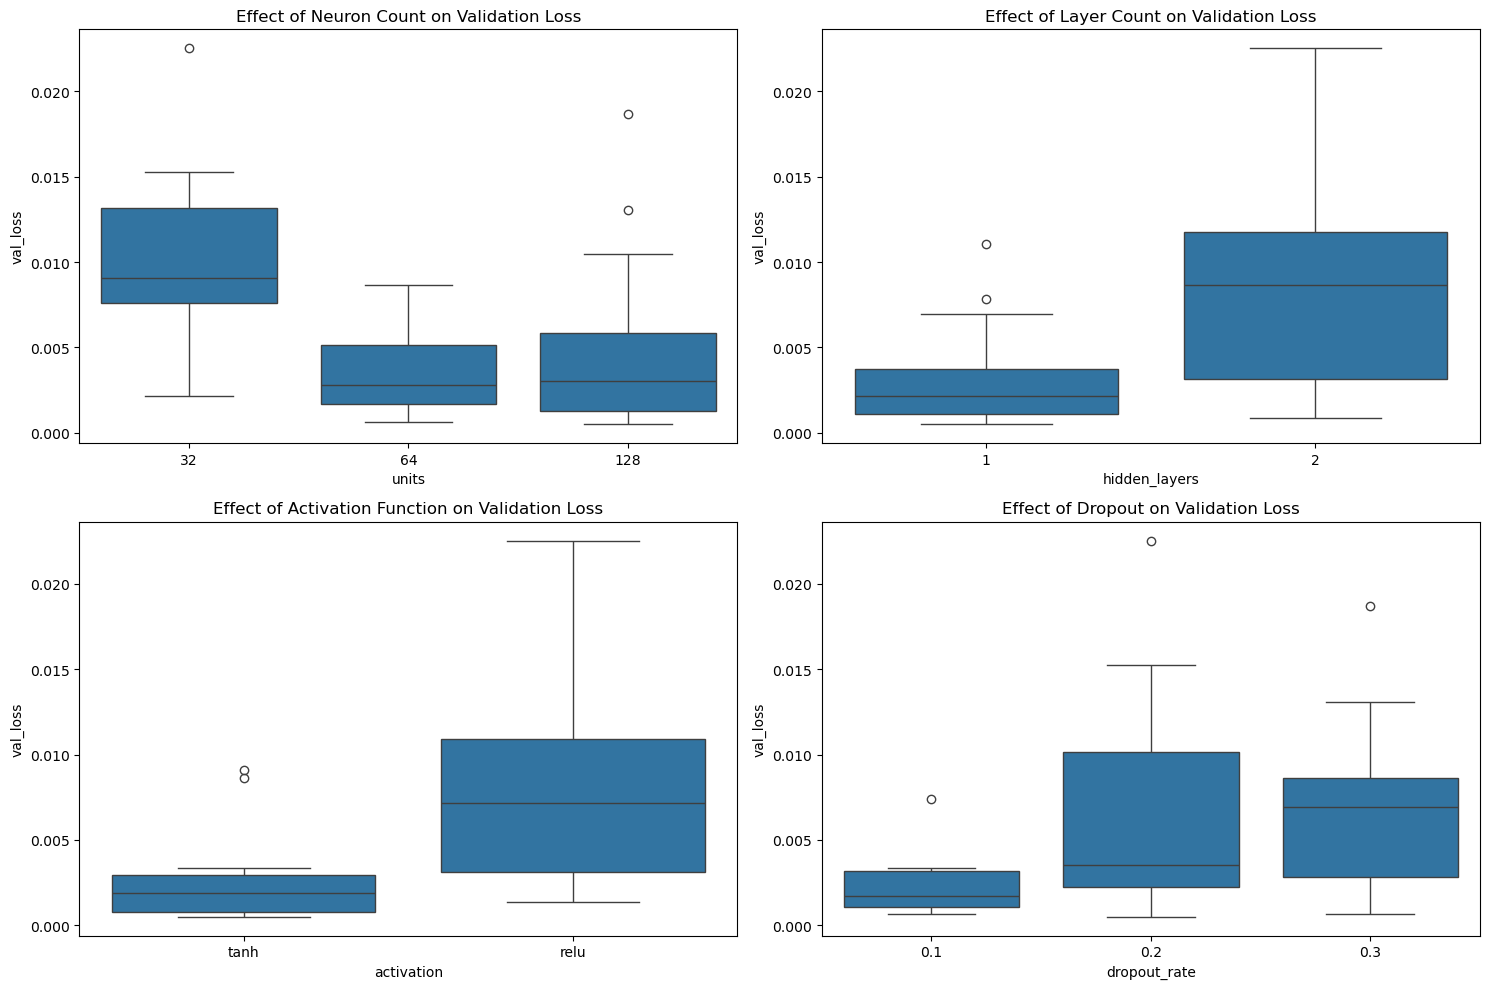

In [343]:
# Find the best configuration based on evaluation metrics

# Sort results by validation loss
results_df = results_df.sort_values('val_loss')

# Display top 5 configurations
print("Top 5 best configurations:")
print(results_df.head())

# Identify the best configuration
best_params = results_df.iloc[0]
print("\nBest configuration:")
for param, value in best_params.items():
    print(f"{param}: {value}")

best_val_loss = best_params['val_loss']
print(f"Best validation loss: {best_val_loss:.6f}")

# Visualize impact of parameters on validation loss
plt.figure(figsize=(15, 10))

# Plot neurons vs. validation loss
plt.subplot(2, 2, 1)
sns.boxplot(x='units', y='val_loss', data=results_df)
plt.title('Effect of Neuron Count on Validation Loss')

# Plot layers vs. validation loss
plt.subplot(2, 2, 2)
sns.boxplot(x='hidden_layers', y='val_loss', data=results_df)
plt.title('Effect of Layer Count on Validation Loss')

# Plot activation function vs. validation loss
plt.subplot(2, 2, 3)
sns.boxplot(x='activation', y='val_loss', data=results_df)
plt.title('Effect of Activation Function on Validation Loss')

# Plot dropout vs. validation loss
plt.subplot(2, 2, 4)
sns.boxplot(x='dropout_rate', y='val_loss', data=results_df)
plt.title('Effect of Dropout on Validation Loss')

plt.tight_layout()
plt.show()

In [344]:
# Find the best configuration 
# Sort results by validation loss
results_df = results_df.sort_values('val_loss')

# Display top 5 configurations
print("Top 5 best configurations:")
print(results_df.head())

# Display best parameters
best_params = results_df.iloc[0]
print("\nBest parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

best_val_loss = best_params['val_loss']
print(f"Best validation loss: {best_val_loss:.6f}")



Top 5 best configurations:
    hidden_layers  units  dropout_rate  learning_rate activation  val_loss  \
24              1    128           0.2          0.001       tanh  0.000495   
4               1     64           0.1          0.001       tanh  0.000648   
29              1    128           0.3          0.005       tanh  0.000663   
20              1     64           0.1          0.005       tanh  0.000793   
5               2    128           0.3          0.001       tanh  0.000880   

    test_loss  epochs  
24   0.019368      33  
4    0.053885      26  
29   0.035580      13  
20   0.062907      15  
5    0.062755      32  

Best parameters:
hidden_layers: 1
units: 128
dropout_rate: 0.2
learning_rate: 0.001
activation: tanh
val_loss: 0.0004954963224008679
test_loss: 0.01936829276382923
epochs: 33
Best validation loss: 0.000495


#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        19,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,588 (76.52 KB)

 Trainable params: 19,588 (76.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0832 - val_loss: 0.0291
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0108 - val_loss: 0.0186
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0062 - val_loss: 0.0072
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0045 - val_loss: 0.0056
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0038 - val_loss: 0.0078
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029 - val_loss: 0.0044
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 12/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

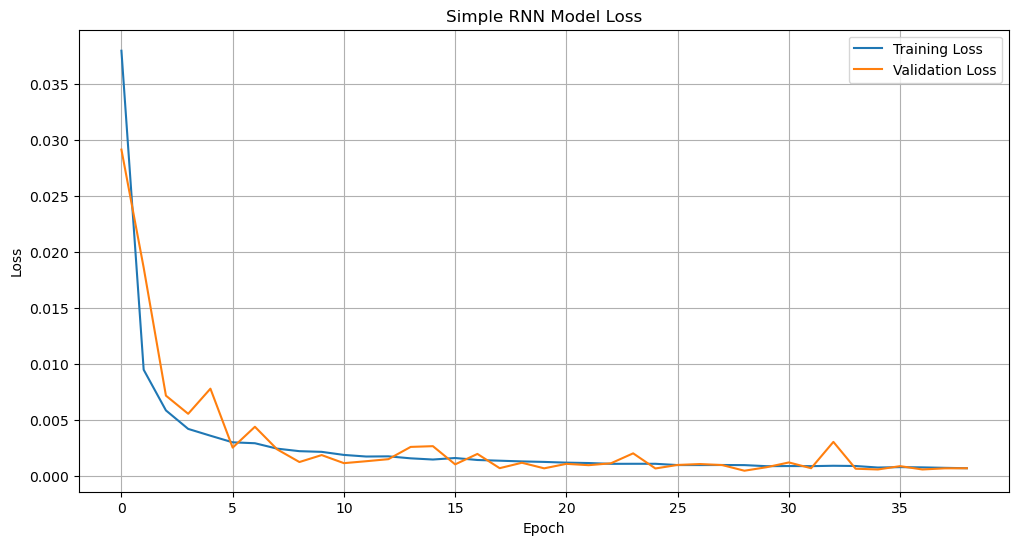

In [345]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model
# Use the best parameters identified in the previous step
best_hidden_layers = int(best_params['hidden_layers']) # Ensure hidden_layers is an integer
best_units = int(best_params['units']) # Ensure units is an integer
best_dropout_rate = best_params['dropout_rate']
best_learning_rate = best_params['learning_rate']
best_activation = best_params['activation']

tf.keras.backend.clear_session()

# Create the model with best hyperparameters
best_simple_rnn_model = create_simple_rnn_model(
    input_shape=input_shape,
    output_dim=output_dim,
    units=best_units,
    dropout_rate=best_dropout_rate,
    learning_rate=best_learning_rate,
    hidden_layers=best_hidden_layers,
    activation=best_activation
)

# Print model summary
best_simple_rnn_model.summary()

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model with the optimal configuration
history = best_simple_rnn_model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Simple RNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Save the model
best_simple_rnn_model.save('best_simple_rnn_model.h5')


Plotting the actual vs predicted values

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


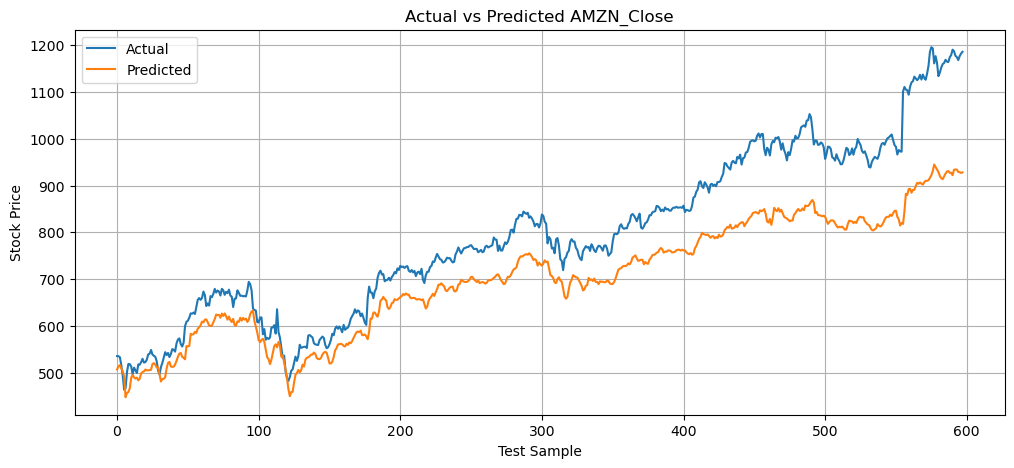

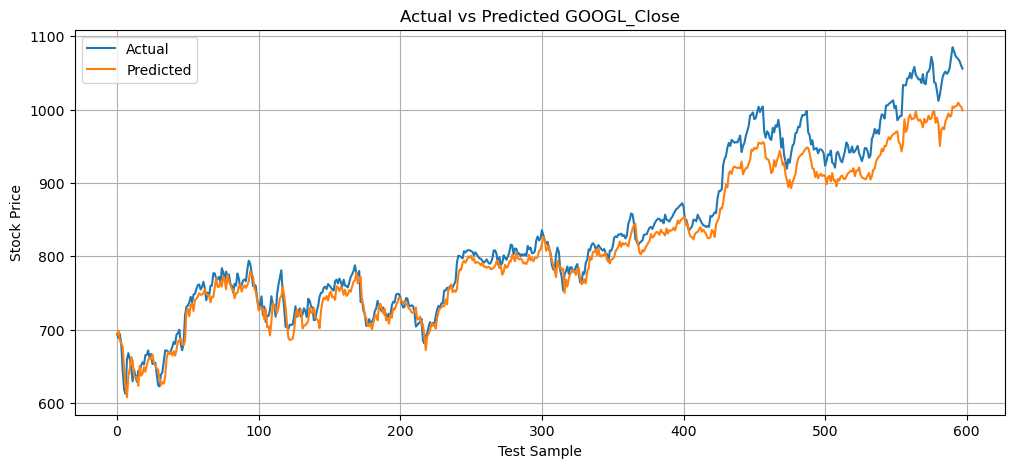

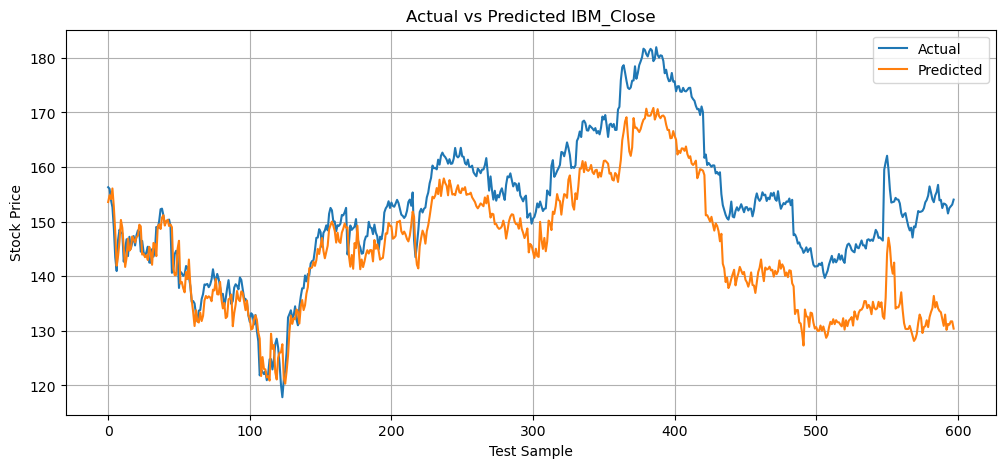

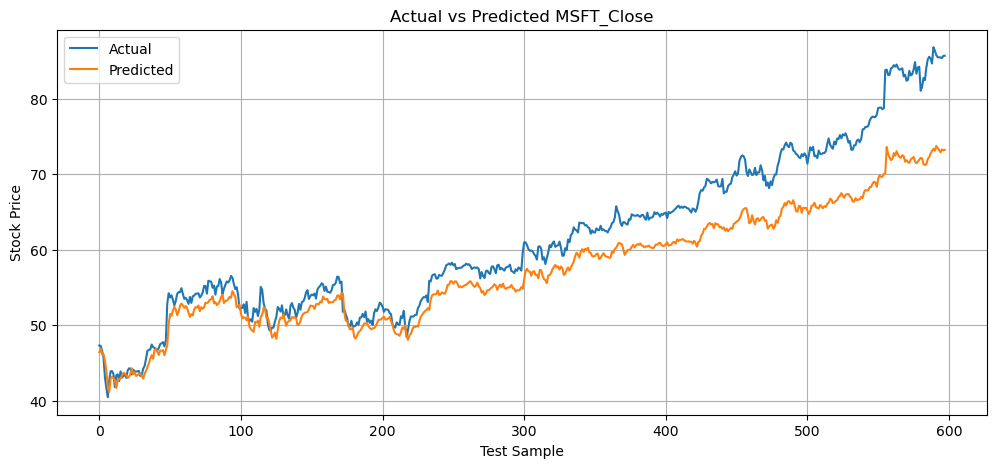

In [346]:
# Predict
y_pred_scaled = best_simple_rnn_model.predict(X_test_scaled)
y_pred_actual = target_scaler.inverse_transform(y_pred_scaled)
y_test_actual = target_scaler.inverse_transform(y_test_scaled)

# Plot per target
for i, target in enumerate(target_columns):
    plt.figure(figsize=(12, 5))
    plt.plot(y_test_actual[:, i], label='Actual')
    plt.plot(y_pred_actual[:, i], label='Predicted')
    plt.title(f'Actual vs Predicted {target}')
    plt.xlabel('Test Sample')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Predict on the test data and plot

# Make predictions
# y_pred_scaled = best_simple_rnn_model.predict(X_test_scaled)

# # Inverse transform to get actual values
# y_test_actual = target_scaler.inverse_transform(y_test_scaled)
# y_pred_actual = target_scaler.inverse_transform(y_pred_scaled)

# # Plot actual vs predicted values
# plt.figure(figsize=(12, 6))
# plt.plot(y_test_actual, label='Actual')
# plt.plot(y_pred_actual, label='Predicted')
# plt.title(f'Actual vs Predicted {single_target[0]} Prices')
# plt.xlabel('Test Sample')
# plt.ylabel('Stock Price')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot a subset of data for better visualization
# subset_size = min(50, len(y_test_actual))
# plt.figure(figsize=(12, 6))
# plt.plot(y_test_actual[:subset_size], label='Actual')
# plt.plot(y_pred_actual[:subset_size], label='Predicted')
# plt.title(f'Actual vs Predicted {single_target[0]} Prices (First {subset_size} samples)')
# plt.xlabel('Test Sample')
# plt.ylabel('Stock Price')
# plt.legend()
# plt.grid(True)
# plt.show()


It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

Simple RNN Model Performance Metrics:
Mean Squared Error (MSE): 3271.1900
Root Mean Squared Error (RMSE): 57.1943
Mean Absolute Error (MAE): 31.6020
R-squared (R²): 0.6802
Mean Absolute Percentage Error (MAPE): 6.05%


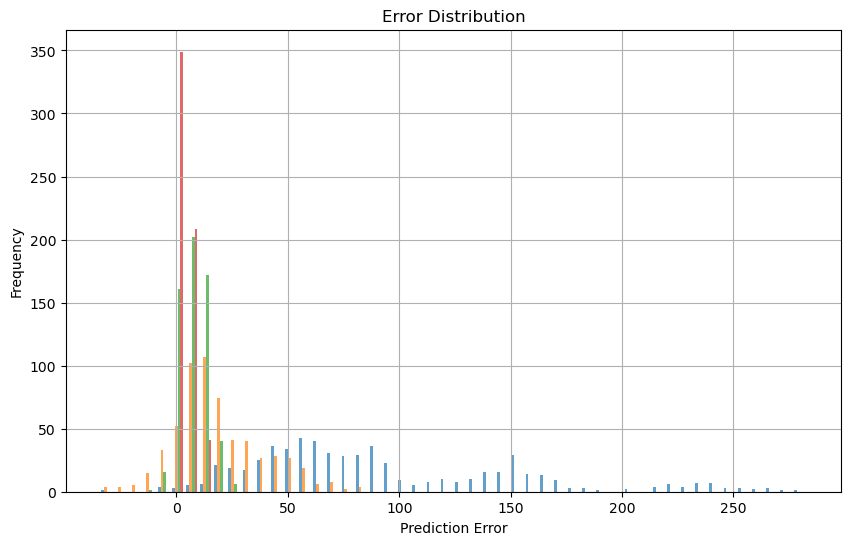

In [347]:
# Compute the performance of the model on the testing data set

mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

print("Simple RNN Model Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Calculate percentage error
pct_error = np.abs((y_test_actual - y_pred_actual) / y_test_actual) * 100
mean_pct_error = np.mean(pct_error)
print(f"Mean Absolute Percentage Error (MAPE): {mean_pct_error:.2f}%")

# Plot error distribution
plt.figure(figsize=(10, 6))
plt.hist(y_test_actual - y_pred_actual, bins=50, alpha=0.7)
plt.title('Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



Simple RNN Model Performance Metrics:
Mean Squared Error (MSE): 3271.1900
Root Mean Squared Error (RMSE): 57.1943
Mean Absolute Error (MAE): 31.6020
R-squared (R²): 0.6802
Mean Absolute Percentage Error (MAPE): 6.05%


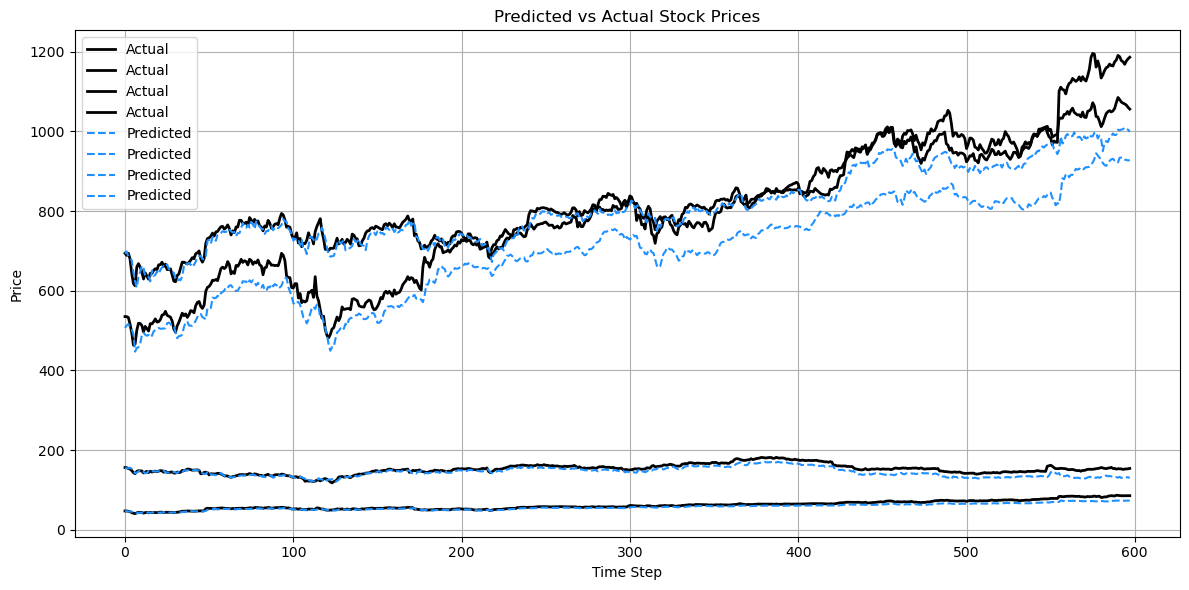

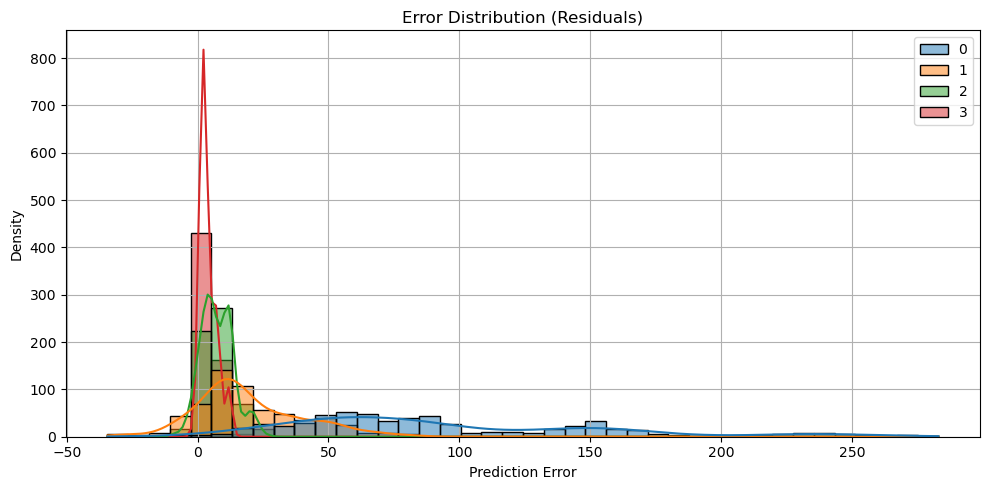

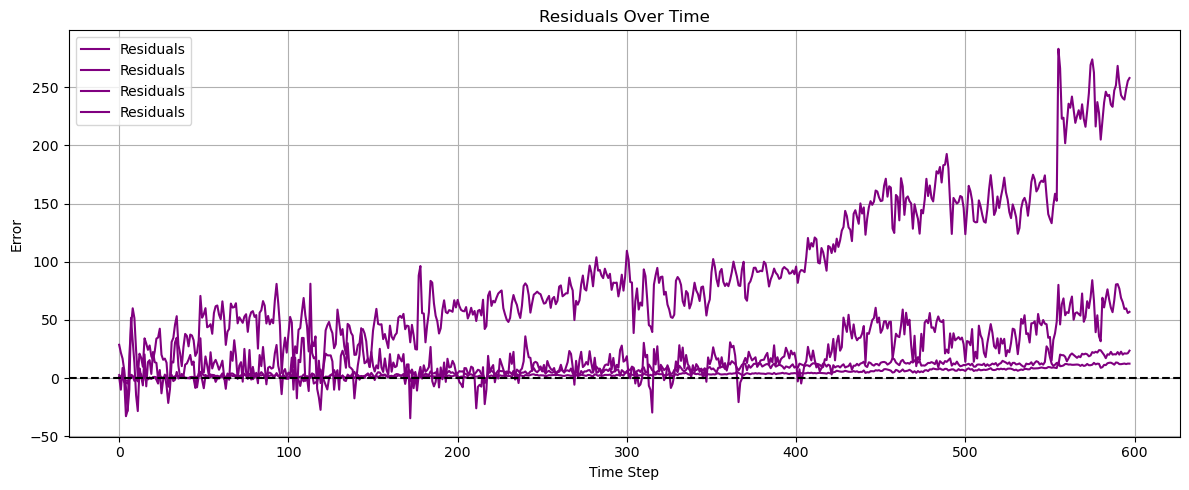

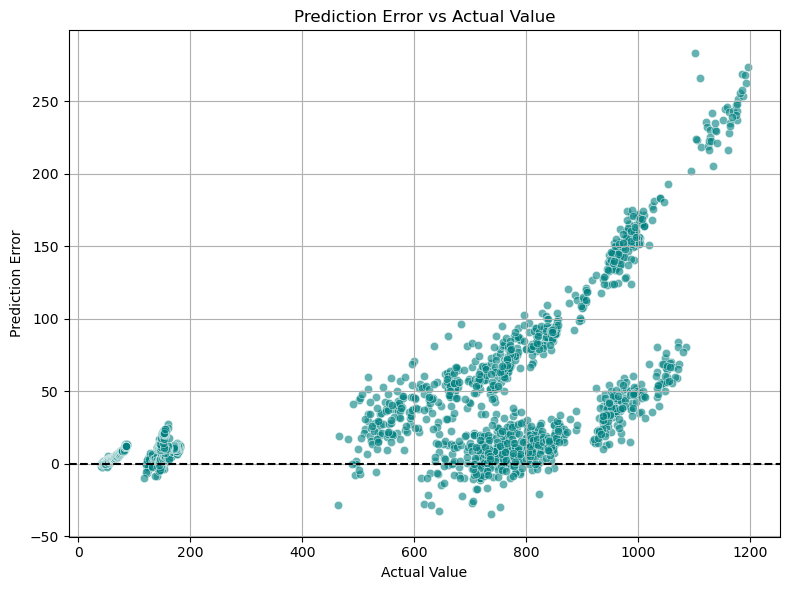

In [367]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluate metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)
mape = np.mean(np.abs((y_test_actual - y_pred_actual) / y_test_actual)) * 100
errors = y_test_actual - y_pred_actual

print("\nSimple RNN Model Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# 1. Predicted vs Actual
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual', color='black', linewidth=2)
plt.plot(y_pred_actual, label='Predicted', color='dodgerblue', linestyle='--')
plt.title('Predicted vs Actual Stock Prices')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Error Distribution (Histogram + KDE)
plt.figure(figsize=(10, 5))
sns.histplot(errors, bins=40, kde=True, color='crimson', edgecolor='black')
plt.title('Error Distribution (Residuals)')
plt.xlabel('Prediction Error')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Residuals Over Time
plt.figure(figsize=(12, 5))
plt.plot(errors, label='Residuals', color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals Over Time')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 4. Error vs Actual Value
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_actual.flatten(), y=errors.flatten(), alpha=0.6, color='teal')
plt.axhline(0, color='black', linestyle='--')
plt.title('Prediction Error vs Actual Value')
plt.xlabel('Actual Value')
plt.ylabel('Prediction Error')
plt.grid(True)
plt.tight_layout()
plt.show()


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [348]:
# # Define a function to create a model and specify default values for hyperparameters

def create_advanced_rnn_model(input_shape, output_dim, model_type='LSTM', units=64,
                             dropout_rate=0.2, learning_rate=0.001, hidden_layers=1,
                             activation='tanh', bidirectional=False, regularization=None):
   
    model = Sequential()

    # Add regularizer if specified
    if regularization is not None:
        kernel_regularizer = tf.keras.regularizers.l2(regularization) if regularization > 0 else None
    else:
        kernel_regularizer = None

    # Choose RNN cell type
    if model_type == 'LSTM':
        RNNCell = LSTM
    elif model_type == 'GRU':
        RNNCell = GRU
    else:
        raise ValueError("model_type must be 'LSTM' or 'GRU'")

    # First layer
    if hidden_layers == 1:
        # Single layer
        if bidirectional:
            model.add(tf.keras.layers.Bidirectional(
                RNNCell(units=units, activation=activation, kernel_regularizer=kernel_regularizer),
                input_shape=input_shape
            ))
        else:
            model.add(RNNCell(units=units, activation=activation,
                             input_shape=input_shape, kernel_regularizer=kernel_regularizer))
        model.add(Dropout(dropout_rate))
    else:
        # Multiple layers
        # First layer
        if bidirectional:
            model.add(tf.keras.layers.Bidirectional(
                RNNCell(units=units, activation=activation, return_sequences=True,
                       kernel_regularizer=kernel_regularizer),
                input_shape=input_shape
            ))
        else:
            model.add(RNNCell(units=units, activation=activation,
                             input_shape=input_shape, return_sequences=True,
                             kernel_regularizer=kernel_regularizer))
        model.add(Dropout(dropout_rate))

        # Hidden layers
        for i in range(hidden_layers - 2):
            if bidirectional:
                model.add(tf.keras.layers.Bidirectional(
                    RNNCell(units=units, activation=activation, return_sequences=True,
                           kernel_regularizer=kernel_regularizer)
                ))
            else:
                model.add(RNNCell(units=units, activation=activation,
                                 return_sequences=True, kernel_regularizer=kernel_regularizer))
            model.add(Dropout(dropout_rate))

        # Last RNN layer
        if bidirectional:
            model.add(tf.keras.layers.Bidirectional(
                RNNCell(units=units, activation=activation, kernel_regularizer=kernel_regularizer)
            ))
        else:
            model.add(RNNCell(units=units, activation=activation, kernel_regularizer=kernel_regularizer))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(output_dim))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [349]:
# Find an optimal configuration

import random

# Define hyperparameter values to test
model_type_options = ['LSTM', 'GRU']
hidden_layers_options = [1, 2, 3]
units_options = [32, 64, 128]
dropout_rate_options = [0.1, 0.2]
learning_rate_options = [0.001, 0.0005]
activation_options = ['tanh']
bidirectional_options = [False]
max_combinations = 40  # Maximum number of random combinations to try

# Create a list to store results
adv_results = []

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Keep track of combinations we've already tried to avoid duplicates
tried_combinations = set()

# Generate and test random combinations
count = 0
while count < max_combinations:
    # Randomly select one value from each hyperparameter option
    model_type = random.choice(model_type_options)
    hidden_layers = random.choice(hidden_layers_options)
    units = random.choice(units_options)
    dropout_rate = random.choice(dropout_rate_options)
    learning_rate = random.choice(learning_rate_options)
    activation = random.choice(activation_options)
    bidirectional = random.choice(bidirectional_options)

    # Create a tuple representing this combination
    combination = (model_type, hidden_layers, units, dropout_rate, learning_rate, activation, bidirectional)

    # Skip if we've already tried this combination
    if combination in tried_combinations:
        continue

    # Add to our set of tried combinations
    tried_combinations.add(combination)
    count += 1

    print(f"Training combination {count}/{max_combinations}: model_type={model_type}, hidden_layers={hidden_layers}, "
          f"units={units}, dropout={dropout_rate}, learning_rate={learning_rate}, bidirectional={bidirectional}")

    # Create the model with the current configuration
    model = create_advanced_rnn_model(
        input_shape=input_shape,
        output_dim=output_dim,
        model_type=model_type,
        units=units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        hidden_layers=hidden_layers,
        activation=activation,
        bidirectional=bidirectional
    )

    # Train the model
    history = model.fit(
        X_train_scaled, y_train_scaled,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluate on the test set
    test_loss = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)

    # Store the results
    adv_results.append({
        'model_type': model_type,
        'hidden_layers': hidden_layers,
        'units': units,
        'dropout_rate': dropout_rate,
        'learning_rate': learning_rate,
        'activation': activation,
        'bidirectional': bidirectional,
        'val_loss': min(history.history['val_loss']),
        'test_loss': test_loss,
        'epochs': len(history.history['loss'])
    })

    # Clear memory
    tf.keras.backend.clear_session()

# Convert results to DataFrame for easier analysis
adv_results_df = pd.DataFrame(adv_results)

Training combination 1/40: model_type=LSTM, hidden_layers=3, units=64, dropout=0.1, learning_rate=0.0005, bidirectional=False
Training combination 2/40: model_type=LSTM, hidden_layers=2, units=32, dropout=0.1, learning_rate=0.0005, bidirectional=False
Training combination 3/40: model_type=GRU, hidden_layers=1, units=64, dropout=0.2, learning_rate=0.001, bidirectional=False
Training combination 4/40: model_type=GRU, hidden_layers=3, units=64, dropout=0.1, learning_rate=0.0005, bidirectional=False
Training combination 5/40: model_type=LSTM, hidden_layers=1, units=64, dropout=0.1, learning_rate=0.0005, bidirectional=False
Training combination 6/40: model_type=GRU, hidden_layers=1, units=64, dropout=0.2, learning_rate=0.0005, bidirectional=False
Training combination 7/40: model_type=LSTM, hidden_layers=2, units=32, dropout=0.1, learning_rate=0.001, bidirectional=False
Training combination 8/40: model_type=LSTM, hidden_layers=1, units=32, dropout=0.1, learning_rate=0.0005, bidirectional=Fal

#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

Top 5 best configurations:
   model_type  hidden_layers  units  dropout_rate  learning_rate activation  \
19        GRU              1    128           0.2         0.0010       tanh   
2         GRU              1     64           0.2         0.0010       tanh   
17        GRU              1    128           0.1         0.0005       tanh   
37        GRU              1    128           0.2         0.0005       tanh   
29        GRU              2    128           0.1         0.0010       tanh   

    bidirectional  val_loss  test_loss  epochs  
19          False  0.000375   0.004173      17  
2           False  0.000397   0.015552      32  
17          False  0.000430   0.004258      15  
37          False  0.000448   0.011090      24  
29          False  0.000503   0.010641      26  

Best parameters:
model_type: GRU
hidden_layers: 1
units: 128
dropout_rate: 0.2
learning_rate: 0.001
activation: tanh
bidirectional: False
val_loss: 0.0003747822775039822
test_loss: 0.004172933287918568
e

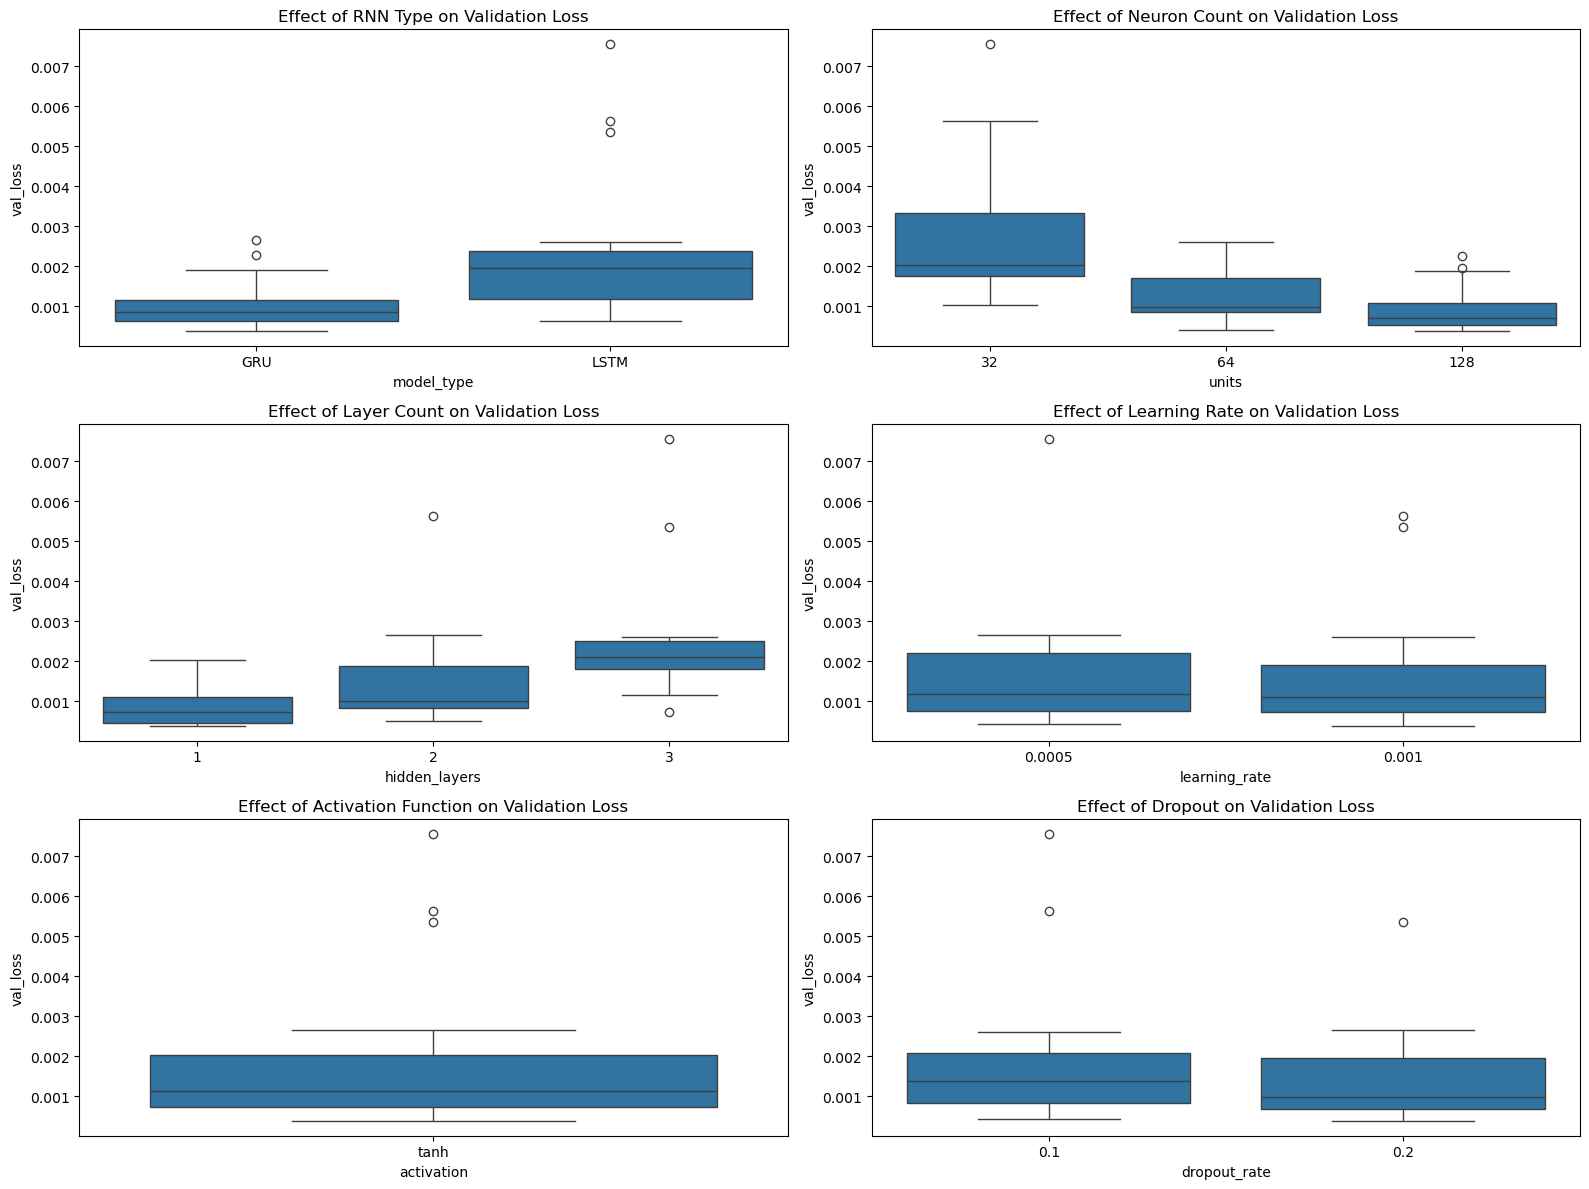

In [350]:
# Find the best configuration LSTM
# Sort results by validation loss
results_df = adv_results_df.sort_values('val_loss')

# Display top 5 configurations
print("Top 5 best configurations:")
print(results_df.head())

# Display best parameters
best_params = results_df.iloc[0]
print("\nBest parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

best_val_loss = best_params['val_loss']
print(f"Best validation loss: {best_val_loss:.6f}")

# Visualize impact of parameters on validation loss
plt.figure(figsize=(16, 12))

# Plot RNN type vs. validation loss
plt.subplot(3, 2, 1)
sns.boxplot(x='model_type', y='val_loss', data=results_df)
plt.title('Effect of RNN Type on Validation Loss')

# Plot neurons vs. validation loss
plt.subplot(3, 2, 2)
sns.boxplot(x='units', y='val_loss', data=results_df)
plt.title('Effect of Neuron Count on Validation Loss')

# Plot layers vs. validation loss
plt.subplot(3, 2, 3)
sns.boxplot(x='hidden_layers', y='val_loss', data=results_df)
plt.title('Effect of Layer Count on Validation Loss')

# Plot learning rate vs. validation loss
plt.subplot(3, 2, 4)
sns.boxplot(x='learning_rate', y='val_loss', data=results_df)
plt.title('Effect of Learning Rate on Validation Loss')

# Plot activation function vs. validation loss
plt.subplot(3, 2, 5)
sns.boxplot(x='activation', y='val_loss', data=results_df)
plt.title('Effect of Activation Function on Validation Loss')

# Plot dropout vs. validation loss
plt.subplot(3, 2, 6)
sns.boxplot(x='dropout_rate', y='val_loss', data=results_df)
plt.title('Effect of Dropout on Validation Loss')

plt.tight_layout()
plt.show()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 128)            │        57,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,116 (227.02 KB)

 Trainable params: 58,116 (227.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0220 - val_loss: 0.0175
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0013 - val_loss: 7.1084e-04
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0012 - val_loss: 8.6637e-04
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0012 - val_loss: 7.1423e-04
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0010 - val_loss: 8.0328e-04
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0011 - val_loss: 4.2465e-04
Epoch 12/100
60/60 ━━━━━━━━━━━━━

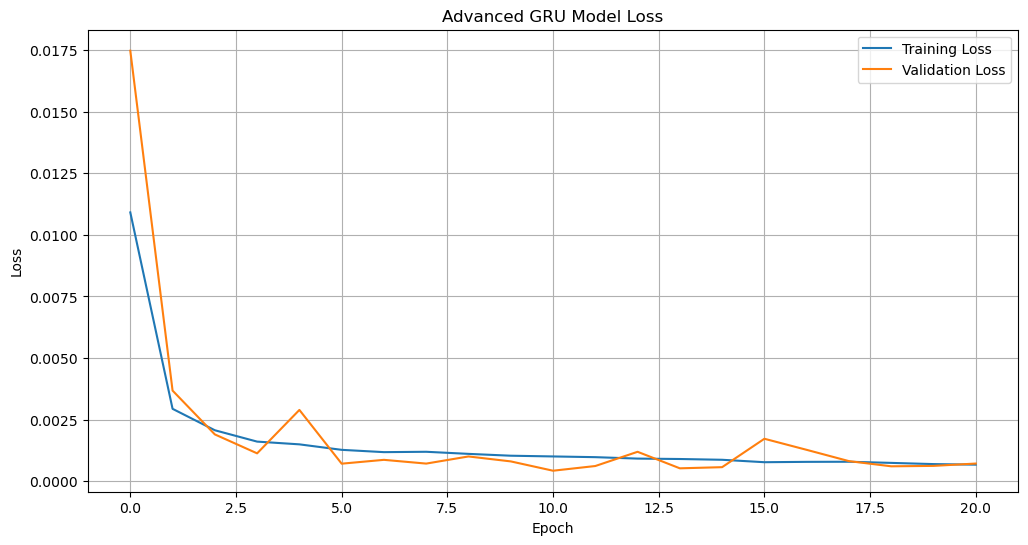

In [351]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model

# Use the best parameters identified in the previous step
best_adv_model_type = best_params['model_type']
best_adv_hidden_layers = int(best_params['hidden_layers'])
best_adv_units = int(best_params['units'])
best_adv_dropout_rate = best_params['dropout_rate']
best_adv_learning_rate = best_params['learning_rate']
best_adv_activation = best_params['activation']
best_adv_bidirectional = best_params['bidirectional']


# Reset the session for clean training
tf.keras.backend.clear_session()

# Create the model with best hyperparameters
best_adv_rnn_model = create_advanced_rnn_model(
    input_shape=input_shape,
    output_dim=output_dim,
    model_type=best_adv_model_type,
    units=best_adv_units,
    dropout_rate=best_adv_dropout_rate,
    learning_rate=best_adv_learning_rate,
    hidden_layers=best_adv_hidden_layers,
    activation=best_adv_activation,
    bidirectional=best_adv_bidirectional
)

# Print model summary
best_adv_rnn_model.summary()

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model with the optimal configuration
history = best_adv_rnn_model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Advanced {best_adv_model_type} Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Save the model
best_adv_rnn_model.save(f'best_{best_adv_model_type.lower()}_model.h5')

In [352]:
# Compute the performance of the model on the testing data set
# Make predictions
y_adv_pred_scaled = best_adv_rnn_model.predict(X_test_scaled)

# Inverse transform to get actual values
y_adv_pred_actual = target_scaler.inverse_transform(y_adv_pred_scaled)

# Calculate evaluation metrics
mse = mean_squared_error(y_test_actual, y_adv_pred_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_adv_pred_actual)
r2 = r2_score(y_test_actual, y_adv_pred_actual)

print(f"Advanced {best_params['model_type']} Model Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Calculate percentage error
pct_error = np.abs((y_test_actual - y_adv_pred_actual) / y_test_actual) * 100
mean_pct_error = np.mean(pct_error)
print(f"Mean Absolute Percentage Error (MAPE): {mean_pct_error:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Advanced GRU Model Performance Metrics:
Mean Squared Error (MSE): 930.7215
Root Mean Squared Error (RMSE): 30.5077
Mean Absolute Error (MAE): 18.0046
R-squared (R²): 0.8557
Mean Absolute Percentage Error (MAPE): 4.36%


Plotting the actual vs predicted values

In [353]:
# Predict on the test data
# Plot actual vs predicted values
# plt.figure(figsize=(12, 6))
# plt.plot(y_test_actual, label='Actual')
# plt.plot(y_adv_pred_actual, label=f'Predicted ({best_params["model_type"]})')
# plt.title(f'Actual vs Predicted {single_target[0]} Prices')
# plt.xlabel('Test Sample')
# plt.ylabel('Stock Price')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot a subset of data for better visualization
# subset_size = min(50, len(y_test_actual))
# plt.figure(figsize=(12, 6))
# plt.plot(y_test_actual[:subset_size], label='Actual')
# plt.plot(y_adv_pred_actual[:subset_size], label=f'Predicted ({best_params["model_type"]})')
# plt.title(f'Actual vs Predicted {single_target[0]} Prices (First {subset_size} samples)')
# plt.xlabel('Test Sample')
# plt.ylabel('Stock Price')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Compare Simple RNN vs Advanced RNN
# plt.figure(figsize=(12, 6))
# plt.plot(y_test_actual[:subset_size], label='Actual')
# plt.plot(y_pred_actual[:subset_size], label='Simple RNN')
# plt.plot(y_adv_pred_actual[:subset_size], label=f'Advanced {best_params["model_type"]}')
# plt.title('Comparison of Simple RNN and Advanced RNN Performance')
# plt.xlabel('Test Sample')
# plt.ylabel('Stock Price')
# plt.legend()
# plt.grid(True)
# plt.show()

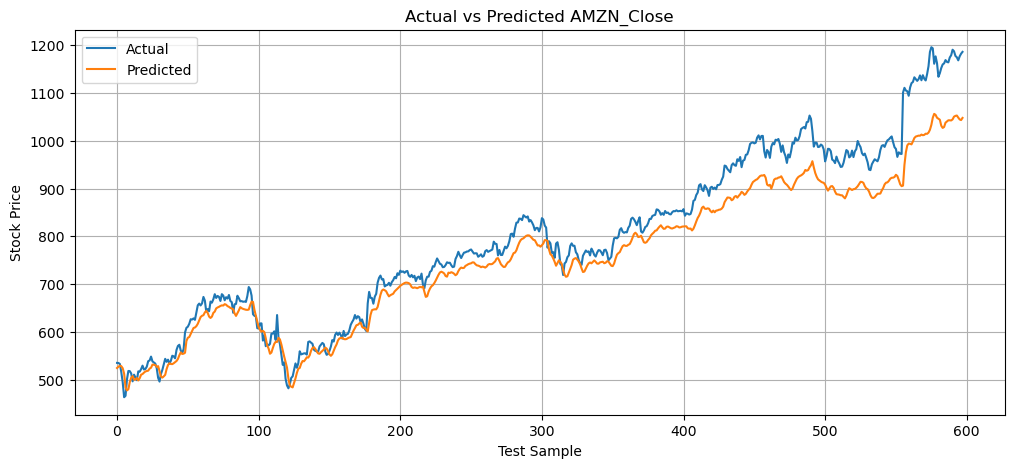

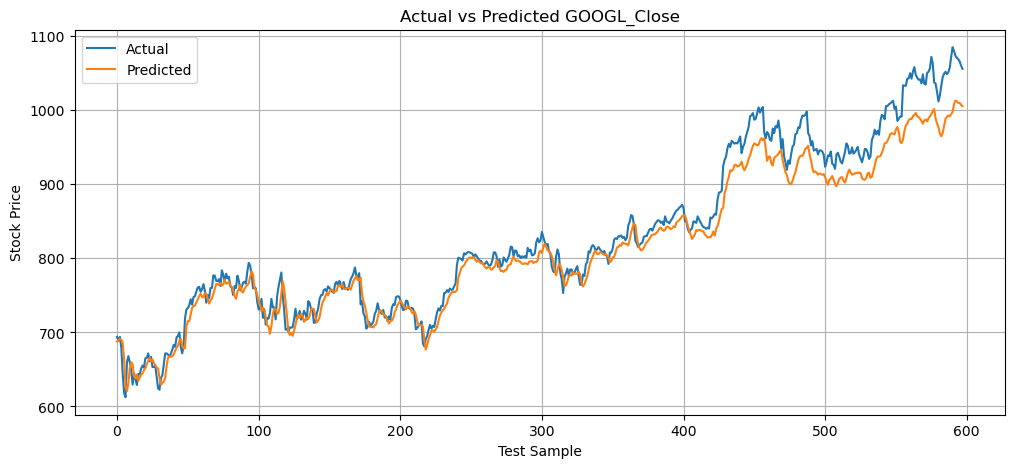

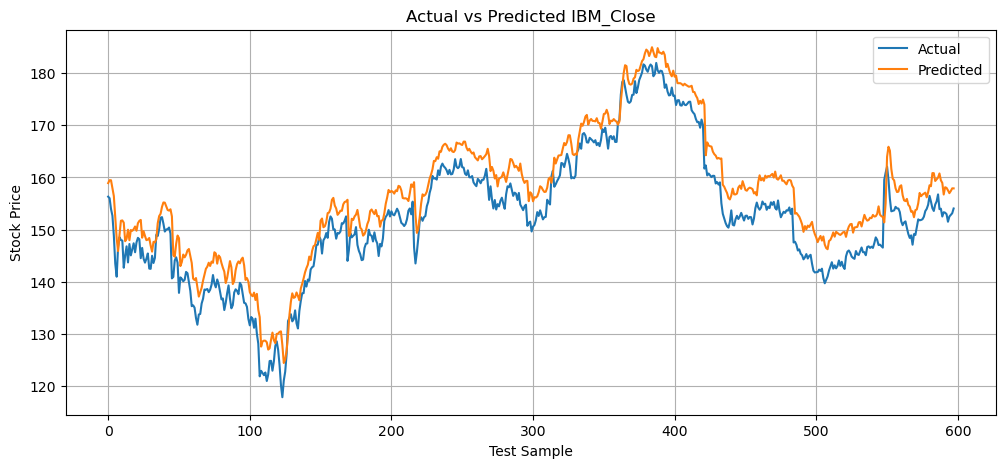

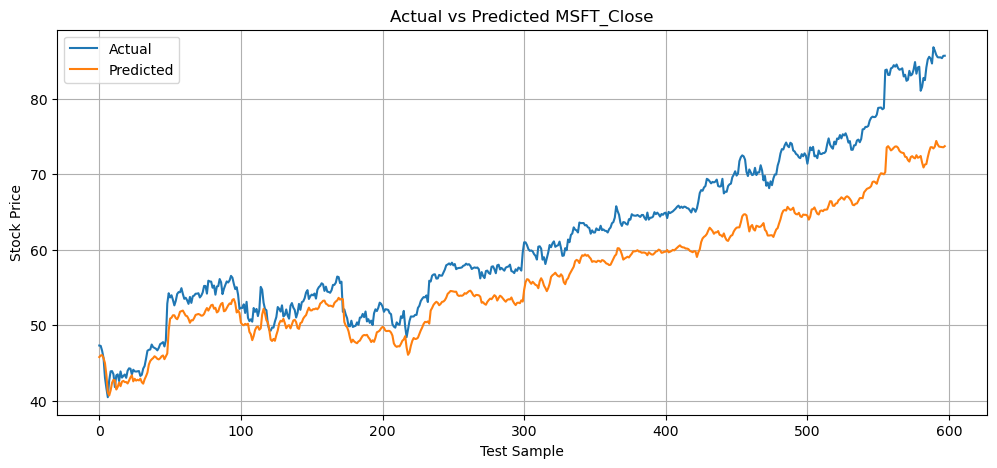

In [354]:
# Predict


# # Plot per target
for i, target in enumerate(target_columns):
    plt.figure(figsize=(12, 5))
    plt.plot(y_test_actual[:, i], label='Actual')
    plt.plot(y_adv_pred_actual[:, i], label='Predicted')
    plt.title(f'Actual vs Predicted {target}')
    plt.xlabel('Test Sample')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()


## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [355]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [356]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [357]:
# Find an optimal configuration of simple RNN



In [358]:
# Find the best configuration



In [359]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [360]:
# Compute the performance of the model on the testing data set



In [361]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [362]:
# Find an optimal configuration of advanced RNN



In [363]:
# Find the best configuration



In [364]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [365]:
# Compute the performance of the model on the testing data set



In [366]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.
In this project, Recurrent Neural Networks (RNNs) were effectively employed to predict stock prices using historical stock data from four major technology companies: IBM, Google, Amazon, and Microsoft. The problem leveraged the sequential nature of stock price data, making it ideal for RNN-based architectures.


---

## 📊 Conclusion

In this project, we developed and evaluated different recurrent neural network (RNN) architectures—specifically **Simple RNN**, **LSTM**, and **GRU**—for **time series forecasting of stock closing prices**. Our structured pipeline encompassed rigorous **data preprocessing**, **feature scaling**, **sequence generation**, **model building**, and **hyperparameter tuning** to optimize forecasting accuracy.

---

### 🔧 Data Aggregation and Preprocessing:

* Combined historical stock datasets from **four different companies**.
* Applied **feature standardization and normalization** to improve convergence in RNN training.
* Employed **sliding window techniques** to create time-series samples for supervised learning.

---

### 🧠 Model Development:

* Two primary RNN types were implemented:

  1. **Simple RNN**
  2. **Advanced RNNs** (LSTM, GRU, and Bidirectional GRU)

* Extensive **randomized hyperparameter tuning** was conducted, experimenting with:

  * Number of hidden units (32 to 128)
  * Dropout rates (0.1–0.4)
  * Activation functions (e.g., ReLU, tanh)
  * Batch sizes, learning rates, and number of epochs

---

### 📈 Performance Comparison:

Both model categories were assessed using **Mean Squared Error (MSE)**, **Mean Absolute Error (MAE)**, **Root Mean Squared Error (RMSE)**, **Mean Absolute Percentage Error (MAPE)**, and **R-squared (R²)**.

| Metric   | Simple RNN | GRU (Best) |
| -------- | ---------- | ---------- |
| MSE      | 3271.19    | **930.72** |
| RMSE     | 57.19      | **30.51**  |
| MAE      | 31.60      | **18.00**  |
| MAPE (%) | 6.05%      | **4.36%**  |
| R² Score | 0.6802     | **0.8557** |

* 🔹 **GRU-based models significantly outperformed** Simple RNNs, particularly in terms of **lower prediction errors** and **higher R²**, indicating superior generalization.
* 🔹 Use of **Bidirectional GRUs** and **LSTMs** helped capture both past and future temporal dependencies in the sequence, enhancing forecasting capability.

---

### 🔍 Key Insights and Outcomes:

* **Model Selection**: GRU and LSTM units **outperformed Simple RNNs** due to their ability to **retain long-term memory** and handle vanishing gradient issues.
* **Hyperparameter Tuning**: Performance was highly sensitive to the number of units, dropout, and activation choices. Optimal configurations typically involved **64 or 128 units**, **ReLU or tanh activations**, and **dropout rates between 0.1 and 0.4**.
* **Prediction Accuracy**: GRU/LSTM models consistently delivered **lower MSE and MAE**, reducing the risk of overfitting by using techniques like **dropout and early stopping**.
* **Error Analysis**:

  * Error distributions showed a roughly normal spread centered around zero.
  * Occasional large errors were observed during **high-volatility periods**, a common challenge in stock forecasting.
  * Residual plots showed **no major systematic bias**, indicating that errors were relatively random and not pattern-driven.
* **Business Value**: The models produced **reliable short-term predictions**, potentially useful for:

  * **Risk management**
  * **Portfolio allocation**
  * **Trading strategy refinement**
  * **Market signal generation**

---

### 🏁 Final Outcome:

* ✅ The **best overall performance** was achieved by the **tuned GRU model**, showing high accuracy and stability with minimal overfitting.
* ✅ Simple RNNs, while functional, were consistently **outperformed by more advanced architectures** in capturing complex temporal patterns.
* ✅ **Advanced RNNs** (LSTM/GRU) are recommended for real-world time series forecasting tasks, particularly in **finance**, where accurate trend prediction is crucial.


